In [1]:
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import pickle
from matplotlib import style
import time
import collections
import random
import math

%matplotlib inline

In [2]:
import keras 

from keras.layers import Lambda, Input, Dense, LSTM, SimpleRNN, GRU
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy, categorical_crossentropy
from keras.utils import plot_model
from keras import backend as K
from keras.regularizers import l1, l2
from keras.utils import np_utils, plot_model
from keras.layers import concatenate
from keras.layers.core import Reshape


import pydot
import tensorflow as tf
import os

Using TensorFlow backend.


In [3]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

[]

# World Creation

In [4]:
class Best_World():

    # Enumeration of possible actions
    class Actions():
        left = 1
        right = 2
        forward = 3
        back = 4
        a = 5
        b = 6
        c = 7
        nothing = 8

    def __init__(
        self,
        grid_size=None,
        max_steps=50,
        obj_reward = 1,
    ):

        # Actions for this environment
        self.actions = {1:"left",2:"right",3:"forward",4:"back",5:"a",6:"b",7:"c",8:"nothing"}
        self.obj_reward = obj_reward
        # Environment configuration
        self.grid_size = grid_size
        self.max_steps = max_steps
        self.grid = np.zeros((grid_size, grid_size, 6), dtype = np.uint8)
        self.end = False
        
        # Current positions of the agents
        self.agent1_pos = None
        self.agent2_pos = None
        
        self.action_costs = [0,0,0,0,0,0,0,0] #[0.2,0.2,0.2,0.2,0.2,0.2,0.2,0]

    def place_object(self, obj_type=1):
        
        x = np.random.randint(0,self.grid_size)
        y = np.random.randint(0,self.grid_size)
        
        
        if obj_type == 1:
            r = 255
            g = 175
            b = 0
            f1 = 1
            f2 = 1
            f3 = 1
            
        if obj_type == 2:
            r = 255
            g = 175
            b = 50
            f1 = 1
            f2 = 0
            f3 = 0
        
        if obj_type == 3: 
            r = 255
            g = 175
            b = 100
            f1 = 1
            f2 = 1
            f3 = 0

        if obj_type == 4:   
            r = 255
            g = 175
            b = 150
            f1 = 1
            f2 = 0
            f3 = 1
            
        if obj_type == 5:      
            r = 255
            g = 1
            b = 50
            f1 = 0
            f2 = 1
            f3 = 1
        
        if obj_type == 6:         
            r = 255
            g = 1
            b = 100
            f1 = 0
            f2 = 1
            f3 = 1
    
        if obj_type == 7:      
            r = 255
            g = 1
            b = 150
            f1 = 0
            f2 = 0
            f3 = 1
            
        if obj_type == 8:        
            r = 255
            g = 1
            b = 200
            f1 = 0
            f2 = 1
            f3 = 0
            
    
        while True:
            if self.grid[x,y,0] == 0: # if nothing is there
                self.grid[x,y,0] = r
                self.grid[x,y,1] = g
                self.grid[x,y,2] = b
                self.grid[x,y,3] = f1
                self.grid[x,y,4] = f2
                self.grid[x,y,5] = f3
                
                break
            else:
                x = np.random.randint(0,self.grid_size)
                y = np.random.randint(0,self.grid_size)
                
    def place_agent(self, num, on_obj=False, x=None, y=None):
        r = 1
        g = 255
        b = 0
        
        if x is None:
            x = np.random.randint(0,self.grid_size)
        else:
            if x > self.grid_size-1: #don't move out of the borders
                x = self.grid_size-1 
            elif x < 0:
                x = 0
                
        if y is None:
            y = np.random.randint(0,self.grid_size)
        else:
            if y > self.grid_size-1:
                y = self.grid_size-1 
            elif y < 0:
                y = 0
        
        if not on_obj: # if agent can't be placed on objects
            while True:
                if self.grid[x,y,0] == 0: # if nothing is there
                    if num == 1:
                        if self.agent1_pos is not None: # if agent already exists
                            prev_pos = self.agent1_pos # remove agent from previous position
                            self.grid[prev_pos[0],prev_pos[1],0] = 0
                            self.grid[prev_pos[0],prev_pos[1],1] = 0
                            self.grid[prev_pos[0],prev_pos[1],2] = 0
                        self.agent1_pos = (x,y) #set a new position
                        self.grid[x,y,0] = r
                        self.grid[x,y,1] = g-25 #one agent is lighter
                        self.grid[x,y,2]= b

                    elif num == 2:
                        if self.agent2_pos is not None:
                            prev_pos = self.agent2_pos # remove agent from previous position
                            self.grid[prev_pos[0],prev_pos[1],0] = 0
                            self.grid[prev_pos[0],prev_pos[1],1] = 0
                            self.grid[prev_pos[0],prev_pos[1],2] = 0
                        self.agent2_pos = (x,y) #set a new position
                        self.grid[x,y,0] = r
                        self.grid[x,y,1] = g
                        self.grid[x,y,2]= b
                    break

                else:
                    if num == 1:
                        if self.agent1_pos is None: # if agent doesn't exist
                            x = np.random.randint(0,self.grid_size)
                            y = np.random.randint(0,self.grid_size)
                        else: # or do not move
                            break
                    elif num == 2:
                        if self.agent2_pos is None: # if agent doesn't exist
                            x = np.random.randint(0,self.grid_size)
                            y = np.random.randint(0,self.grid_size)
                        else:
                            break
                    
        else: 
            if num == 1:
                if self.agent1_pos is not None: # if agent already exists
                    prev_pos = self.agent1_pos # remove agent from previous position
                    self.grid[prev_pos[0],prev_pos[1],0] = 0
                    self.grid[prev_pos[0],prev_pos[1],1] = 0
                    self.grid[prev_pos[0],prev_pos[1],2] = 0
                self.agent1_pos = (x,y) #set a new position
                self.grid[x,y,0] = r
                self.grid[x,y,1] = g-55 #one agent is lighter
                self.grid[x,y,2]= b
                
            elif num == 2:
                if self.agent2_pos is not None:
                    prev_pos = self.agent2_pos # remove agent from previous position
                    self.grid[prev_pos[0],prev_pos[1],0] = 0
                    self.grid[prev_pos[0],prev_pos[1],1] = 0
                    self.grid[prev_pos[0],prev_pos[1],2] = 0
                self.agent2_pos = (x,y) #set a new position
                self.grid[x,y,0] = r
                self.grid[x,y,1] = g
                self.grid[x,y,2]= b
                
    def step(self, ag1_action, ag2_action, step_i, reward1 = 0, reward2 = 0):
        
        ag1_input = np.resize(self.grid[:,:,3:6],(self.grid_size*self.grid_size*3,)) # make a single column
        ag1_input = np.concatenate((ag1_input, np.zeros((3)))) # add 3 "phonemes"
        ag2_input = ag1_input.copy()
        
        if ag1_action == 5:
            ag2_input[-3] = 1
        elif ag1_action == 6:
            ag2_input[-2] = 1
        elif ag1_action == 7:
            ag2_input[-1] = 1
            
        if ag2_action == 5:
            ag1_input[-3] = 1
        elif ag2_action == 6:
            ag1_input[-2] = 1
        elif ag2_action == 7:
            ag1_input[-1] = 1
        
        # agent 1 moving?
        x = self.agent1_pos[0]
        y = self.agent1_pos[1]
        if ag1_action == 1: # left
            x -= 1    
        elif ag1_action == 2: # right
            x += 1
        elif ag1_action == 3: # forward
            y += 1
        elif ag1_action == 4: # backward
            y -= 1
            
        self.place_agent(1, True, x, y)
        
        # agent 2 moving?
        x = self.agent2_pos[0]
        y = self.agent2_pos[1]
        if ag2_action == 1: # left
            x -= 1    
        elif ag2_action == 2: # right
            x += 1
        elif ag2_action == 3: # forward
            y += 1
        elif ag2_action == 4: # backward
            y -= 1
            
        self.place_agent(2, True, x, y)
        
        ag1_input = np.concatenate((ag1_input, np.array(self.agent1_pos))) # add agent position as input
        ag1_input = np.concatenate((ag1_input, np.array(self.agent2_pos))) # add the other agent position as input (for some simulations)
        
        ag2_input = np.concatenate((ag2_input, np.array(self.agent2_pos))) # add agent position as input
        ag2_input = np.concatenate((ag2_input, np.array(self.agent1_pos))) # other agent's position

        
        reward1 += self.action_costs[ag1_action-1]
        reward2 += self.action_costs[ag2_action-1]
        
        # rewards for bumping into objects
        if self.grid[self.agent1_pos[0],self.agent1_pos[1],3] == 1 or self.grid[self.agent1_pos[0],self.agent1_pos[1],4] == 1 or self.grid[self.agent1_pos[0],self.agent1_pos[1],5] == 1:
            reward1 += self.obj_reward
                
        if self.grid[self.agent2_pos[0],self.agent2_pos[1],3] == 1 or self.grid[self.agent2_pos[0],self.agent2_pos[1],4] == 1 or self.grid[self.agent2_pos[0],self.agent2_pos[1],5] == 1:
            reward2 += self.obj_reward
        
        if self.agent1_pos == self.agent2_pos and (self.grid[self.agent2_pos[0],self.agent2_pos[1],3] == 1 or self.grid[self.agent2_pos[0],self.agent2_pos[1],4] == 1 or self.grid[self.agent2_pos[0],self.agent2_pos[1],5] == 1):
            # winning game reward
            reward1 += 100
            reward2 += 100
            self.end = True # end the game
        
        #end game if reached maximum number of steps 
        elif step_i >= self.max_steps:
            self.end = True
            reward1 = 0
            reward2 = 0
        
        return(ag1_input, ag2_input, reward1, reward2, self.end)
    
    #visualization
    def show_world(self):
        img = Image.fromarray(self.grid[:,:,0:3], "RGB")
        img = img.resize((300,300))
        cv2.imshow("00", np.array(img))
        return(None)
        

In [5]:
def reset_env(size, num_obj):
    # world
    my_world = Best_World(size)
    # agents
    my_world.place_agent(1)
    my_world.place_agent(2)

    # random objects
    for i in range(num_obj):
        obj_type = np.random.randint(8)+1
        my_world.place_object(obj_type)
    
    return my_world

In [6]:
def vis_grid(env):
    img = Image.fromarray(env.grid[:,:,0:3], "RGB")
    img = img.resize((300,300))
    img = img.rotate(90)
    cv2.imshow('image',np.array(img))
    # saving the image
    cv2.imwrite('img.png',np.array(img))
    cv2.waitKey(1)    

### Birth of the agents!!!

In [52]:
# Deep Q-learning Agent
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = collections.deque(maxlen=2000)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()
    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse',
                      optimizer=Adam(lr=self.learning_rate))
        return model
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        state = np.expand_dims(state, axis=0)
        act_values = self.model.predict(state, batch_size=1)
        return np.argmax(act_values[0])  # returns action from 0 to n-1
    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            next_state = np.expand_dims(next_state, axis=0)
            state = np.expand_dims(state, axis=0)
            target = reward
            if not done:
                target = reward + self.gamma * 
                       np.amax(self.model.predict(next_state, batch_size=1)[0])
            target_f = self.model.predict(state, batch_size=1)
            target_f[0][action] = target
            self.model.fit(state, target_f, batch_size=1, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [55]:
env_size = 8
num_obj = 8
episodes = 500
every = 100
print_every = 10

scores1 = []
scores2 = []
    
agent1 = DQNAgent(199, 8)
agent2 = DQNAgent(199, 8)

# Iterate the game
for e in range(episodes):
    # reset environment in the beginning of each game
    env = reset_env(env_size, num_obj)
    state1, state2, _, _, _ = env.step(8, 8, 0)
    score1 = 0
    score2 = 0
    incr = []
    for time_t in range(50):
        
        action1 = agent1.act(state1)
        action2 = agent2.act(state2)
        
        # agents act on the environment
        next_state1, next_state2, reward1, reward2, done = env.step(action1+1, action2+1, time_t)
        
        score1 += reward1
        score2 += reward2
        
        # store the experience
        agent1.remember(state1, action1, reward1, next_state1, done)
        agent2.remember(state2, action2, reward2, next_state2, done)
        
        # make next_state the new current state for the next timestep
        state1 = next_state1
        state2 = next_state2
        
        
        if e % every == 0:
            vis_grid(env)
        if done:
            break
        # train the agent with the experience of the episode
    score1 = round(score1, 2)
    score2 = round(score2, 2)
    print("episode: {}/{}, score1: {}, score2: {}, steps: {}"
                  .format(e, episodes, score1, score2, time_t))
    
    # learn after each game
    agent1.replay(32)
    agent2.replay(32)
    
    scores1.append(score1)
    scores2.append(score2)

episode: 0/500, score1: 3, score2: 10, steps: 49
episode: 1/500, score1: 5, score2: 0, steps: 49
episode: 2/500, score1: 8, score2: 0, steps: 49
episode: 3/500, score1: 10, score2: 1, steps: 49
episode: 4/500, score1: 12, score2: 4, steps: 49
episode: 5/500, score1: 4, score2: 13, steps: 49
episode: 6/500, score1: 10, score2: 9, steps: 49
episode: 7/500, score1: 102, score2: 106, steps: 29
episode: 8/500, score1: 13, score2: 6, steps: 49
episode: 9/500, score1: 0, score2: 0, steps: 49
episode: 10/500, score1: 6, score2: 7, steps: 49
episode: 11/500, score1: 1, score2: 14, steps: 49
episode: 12/500, score1: 8, score2: 0, steps: 49
episode: 13/500, score1: 116, score2: 111, steps: 47
episode: 14/500, score1: 107, score2: 113, steps: 40
episode: 15/500, score1: 3, score2: 7, steps: 49
episode: 16/500, score1: 0, score2: 10, steps: 49
episode: 17/500, score1: 5, score2: 11, steps: 49
episode: 18/500, score1: 19, score2: 8, steps: 49
episode: 19/500, score1: 7, score2: 4, steps: 49
episode:

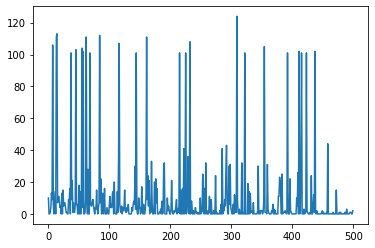

In [56]:
plt.plot(scores2)

### Recurrent agents

In [165]:
# Deep Q-learning Agent
class DQRNAgent:
    def __init__(self, state_size, action_size, episodes_len, obs_from_ep = 1):
        self.state_size = (1,1,state_size)
        self.action_size = action_size
        self.memory = collections.deque(maxlen=300)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.episodes_len = episodes_len
        self.obs_from_ep = obs_from_ep
        self.model = self._build_model()
        
    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(Dense(56, batch_input_shape=self.state_size, activation='relu'))
        #model.add(Dense(16, batch_input_shape=self.state_size, activation='relu'))
        model.add(LSTM(32, return_sequences = True, stateful = True))
        model.add(LSTM(32, return_sequences = True, stateful = True))
        #model.add(Dense(16, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='MSE',
                      optimizer=Adam(lr=self.learning_rate))
        return model
    
    def remember(self, experience):
        self.memory.append((experience))
        
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        state = np.expand_dims(state, axis=0)
        state = np.expand_dims(state, axis=0)
        act_values = self.model.predict(state, batch_size=1)
        return np.argmax(act_values[0,0,:])  # returns action
    
    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size) #len(self.memory))
        
        # weighted sampling with successful games gaining more weight
        #minibatch = [] 
        #for i in range(batch_size):
        #    while True:
        #        exp = random.choice(self.memory)
        #        if random.random() < (exp[-1][2]+30)/100: # sampling 'proportional' to the reward, failed game experiences are kept at the rate p
        #            minibatch.append(exp)
        #            break
        
        for experience in minibatch:
            
            if len(experience) < self.episodes_len: # break if the episode is shorter than rnn seq len
                break
                
            if len(experience)/2 >= self.episodes_len:
                experience = experience[math.floor(len(experience)/2):] # sample from the second half of the experiences - more likely to learn from successes
            
            # for all the sequences in the sampled memory trace
            #for first_obs_idx in range(0, len(experience)-self.episodes_len):
            
            # several (or one) seq samples from sampled experience
            for d in range(self.obs_from_ep): 
                #first_obs_idx = random.randint(0, math.ceil((1/2)*len(experience)-self.episodes_len)) + math.floor((1/2)*len(experience)) # randomize from the last half of the experience
                first_obs_idx = random.randint(0, len(experience)-self.episodes_len)
                states = []
                targets = []
                actions = []
                for i in range(first_obs_idx, first_obs_idx+self.episodes_len):
                    obs = experience[i]
                    state = obs[0]
                    action = obs[1]
                    reward = obs[2]
                    next_state = obs[3]
                    done = obs[4]
                    next_state = np.expand_dims(next_state, axis=0)
                    next_state = np.expand_dims(next_state, axis=0)
                    state = np.expand_dims(state, axis=0)
                    state = np.expand_dims(state, axis=0)
                    states.append(state)
                    actions.append(action)
                    target = reward
                        #cur_states = [current_state, next_state]
                        #cur_states = np.expand_dims(cur_states, axis = 0)
                    if not done:
                        self.model.predict(state, batch_size=1)
                        target = reward + self.gamma * np.amax(self.model.predict(next_state, batch_size=1)[0,0,:]) #check
                        self.model.reset_states()
                    targets.append(target)
                self.model.reset_states()
                for k in range(self.episodes_len):
                    target_f = self.model.predict(states[k], batch_size=1)
                    target_f[0,0,actions[k]] = targets[k]
                    self.model.fit(states[k], target_f, batch_size=1, epochs=3, verbose=0)
                self.model.reset_states() # important!
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        else:
            self.epsilon = self.epsilon_min  

In [33]:
env_size = 8
num_obj = 12
episodes = 1000
every = 10
print_every = 10
replay_exp_length = 10

scores1 = []
scores2 = []
    
agent1 = DQRNAgent(199, 8, replay_exp_length)
agent2 = DQRNAgent(199, 8, replay_exp_length)

In [69]:
# Iterate the game
episodes = 2000

for e in range(episodes):
    # reset state in the beginning of each game
    env = reset_env(env_size, num_obj)
    state1, state2, _, _, _ = env.step(8, 8, 0)
    score1 = 0
    score2 = 0
    # to store full experience traces
    experience1 = []
    experience2 = []
    prev_done = False
    for time_t in range(70):
        
        action1 = agent1.act(state1)
        action2 = agent2.act(state2)
            # Advance the game to the next frame based on the action.
            # Reward is 1 for every frame the pole survived
        next_state1, next_state2, reward1, reward2, done = env.step(action1, action2, time_t)
        
        experience1.append([state1, action1, reward1, next_state1, done]) #prev_done])
        experience2.append([state2, action2, reward2, next_state2, done]) #prev_done])        
        
        score1 += reward1
        score2 += reward2
        
        #next_state = np.reshape(next_state, [1, 4])
        
        state1 = next_state1
        state2 = next_state2
        
        # break one step after the game ended
        if prev_done:
            break

        #if e % every == 0:
            #vis_grid(env)

        prev_done = done
    
    # remember the whole experience traces
    agent1.remember(experience1)
    agent2.remember(experience2)
    
    agent1.model.reset_states()
    agent2.model.reset_states()
    
    score1 = round(score1, 2)
    score2 = round(score2, 2)
    print("episode: {}/{}, score1: {}, score2: {}, steps: {}"
                  .format(e, episodes, score1, score2, time_t))
    if e > 32: #and e%100 == 0:
        agent1.replay(32)
        agent2.replay(32)
    
    scores1.append(score1)
    scores2.append(score2)

episode: 0/2000, score1: 0, score2: 23, steps: 51
episode: 1/2000, score1: 6, score2: 2, steps: 51
episode: 2/2000, score1: 13, score2: 8, steps: 51
episode: 3/2000, score1: 10, score2: 5, steps: 51
episode: 4/2000, score1: 7, score2: 7, steps: 51
episode: 5/2000, score1: 12, score2: 10, steps: 51
episode: 6/2000, score1: 6, score2: 12, steps: 51
episode: 7/2000, score1: 4, score2: 0, steps: 51
episode: 8/2000, score1: 7, score2: 0, steps: 51
episode: 9/2000, score1: 2, score2: 5, steps: 51
episode: 10/2000, score1: 2, score2: 12, steps: 51
episode: 11/2000, score1: 13, score2: 20, steps: 51
episode: 12/2000, score1: 1, score2: 13, steps: 51
episode: 13/2000, score1: 4, score2: 6, steps: 51
episode: 14/2000, score1: 14, score2: 3, steps: 51
episode: 15/2000, score1: 13, score2: 6, steps: 51
episode: 16/2000, score1: 0, score2: 3, steps: 51
episode: 17/2000, score1: 2, score2: 21, steps: 51
episode: 18/2000, score1: 7, score2: 17, steps: 51
episode: 19/2000, score1: 7, score2: 9, steps:

KeyboardInterrupt: 

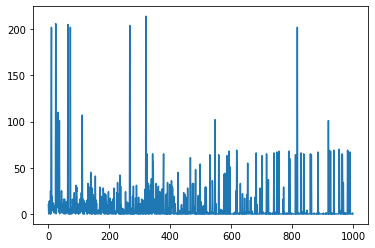

In [26]:
plt.plot(scores2)

## Simple Adversarial Game

In [39]:
np.random.normal(0,0.2,(4,))

array([-0.06860818,  0.23332452,  0.00564594, -0.1624473 ])

In [7]:
class Second_Best_World():

    # Enumeration of possible actions
    class Actions():
        a = 1
        b = 2
        c = 3
        nothing = 4
        # choose entity - entity number (the range(num of entities))

    def __init__(
        self,
        num_ent, winning_reward, talking_reward, 
        max_steps=4):

        # Action enumeration for this environment
        d = {1:"a",2:"b",3:"c",4:"nothing"}
        for i in range(num_ent):
            d[i+5] = str(i+1)
        self.actions = d
        self.num_ent = num_ent
        self.winning_reward = winning_reward
        self.talking_reward = talking_reward
        self.max_steps = max_steps
        self.talking_decay = 0.995
        self.end = False   
                
    def step(self, ag1_action, ag2_action, ag3_action, step_i, reward1 = 0, reward2 = 0, reward3 = 0):
        self.end = False
        ag3_input = np.array([random.random()]) # adversarial agent does not know anything
        
        ag1_input = np.random.normal(0,0.2,(4,))
        ag2_input = np.random.normal(0,0.2,(4,))
        
        #ag1_input[1] = random.random()
        #ag2_input[1] = random.random()
        #ag1_input[2] = random.random()
        #ag2_input[2] = random.random()
        #ag1_input[3] = random.random()
        #ag2_input[3] = random.random()
        
        ag2_action = ag2_action+1
        ag1_action = ag1_action+1
        ag3_action = ag3_action+5
        
        # agent 1 talking
        if ag1_action == 1:
            ag2_input[0] += 1
            reward1 = self.talking_decay = 0.995 * self.talking_reward
        elif ag1_action == 2:
            ag2_input[1] += 1
            reward1 = self.talking_decay = 0.995 * self.talking_reward
        elif ag1_action == 3:
            ag2_input[2] += 1
            reward1 = self.talking_decay = 0.995 * self.talking_reward
        
        #agent 2 talking
        if ag2_action == 1:
            ag1_input[0] += 1 
            reward2 = self.talking_decay = 0.995 * self.talking_reward
        elif ag2_action == 2:
            ag1_input[1] += 1 
            reward2 = self.talking_decay = 0.995 * self.talking_reward
        elif ag2_action == 3:
            ag1_input[2] += 1
            reward2 = self.talking_decay = 0.995 * self.talking_reward
        
        # agent 1 choosing an entity?
        if ag1_action > 4 or ag2_action > 4:
            self.end = True # end the game
            if ag2_action == ag1_action: 
                if ag3_action == ag2_action: #caught in place
                    reward3 = 1
                    reward1 = -1
                    reward2 = -1
                else:
                    reward3 = -1
                    reward1 = self.winning_reward
                    reward2 = self.winning_reward
            else:
                reward1 = -1
                reward2 = -1
                if ag1_action == ag3_action or ag2_action == ag3_action:
                    reward3 = 1
                else:
                    reward3 = -1
                            
        #end game if reached maximum number of steps 
        elif step_i >= self.max_steps:
            self.end = True
            reward1 = -1
            reward2 = -1
            reward3 = 0
        
        return(ag1_input, ag2_input, ag3_input, reward1, reward2, reward3, self.end)

In [40]:
# Deep Q-learning Agent
class DQRNAgent:
    def __init__(self, state_size, action_size, episodes_len, obs_from_ep = 1):
        self.state_size = (1,1,state_size)
        self.action_size = action_size
        self.memory = collections.deque(maxlen=100)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.1
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.episodes_len = episodes_len
        self.obs_from_ep = obs_from_ep
        self.model = self._build_model()
        
        
    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(LSTM(4, batch_input_shape=self.state_size, return_sequences = True, stateful = True))
        model.add(LSTM(4, batch_input_shape=self.state_size, return_sequences = True, stateful = True))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='MSE',
                      optimizer=Adam(lr=self.learning_rate))
        return model
    
    def remember(self, experience):
        self.memory.append((experience))
        
    def act(self, state):
        if np.random.rand() <= self.epsilon: # explore
            return random.randrange(self.action_size)
        state = np.expand_dims(state, axis=0) 
        state = np.expand_dims(state, axis=0)
        act_values = self.model.predict(state, batch_size=1)
        return np.argmax(act_values[0,0,:]) # exploit
    
    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size) #len(self.memory))
        #minibatch = [] # weighted sampling with successful games gaining more weight
        #for i in range(batch_size):
        #    while True:
        #        exp = random.choice(self.memory)
        #        if random.random() < (exp[-1][2]+2.2): # sampling 'proportional' to the reward, failed game experiences are kept at the 0.2 rate
        #            minibatch.append(exp)
        #            break
        
        for experience in minibatch:
            
            if len(experience) < self.episodes_len: # break if the episode is shorter than rnn seq len
                break
                
            #if len(experience)/2 >= self.episodes_len:
            #    experience = experience[math.floor(len(experience)/2):] # sample from the second half of the experiences
            
            #for first_obs_idx in range(0, len(experience)-self.episodes_len):
            for d in range(self.obs_from_ep): # several samples from sampled experience
                #first_obs_idx = random.randint(0, math.ceil((1/2)*len(experience)-self.episodes_len)) + math.floor((1/2)*len(experience)) # randomize from the last half of the experience
                first_obs_idx = random.randint(0, len(experience)-self.episodes_len)
                states = []
                targets = []
                actions = []
                for i in range(first_obs_idx, first_obs_idx+self.episodes_len):
                    #if i % 4 != 0: # every
                    #    pass
                    obs = experience[i]
                    state = obs[0]
                    action = obs[1]
                    reward = obs[2]
                    next_state = obs[3]
                    done = obs[4]
                    next_state = np.expand_dims(next_state, axis=0)
                    next_state = np.expand_dims(next_state, axis=0)
                    state = np.expand_dims(state, axis=0)
                    state = np.expand_dims(state, axis=0)
                    states.append(state)
                    actions.append(action)
                    target = reward
                        #cur_states = [current_state, next_state]
                        #cur_states = np.expand_dims(cur_states, axis = 0)
                    if not done:
                        self.model.predict(state, batch_size=1)
                        target = reward + self.gamma * np.amax(self.model.predict(next_state, batch_size=1)[0,0,:]) #check
                        self.model.reset_states()
                    targets.append(target)
                self.model.reset_states()
                for k in range(self.episodes_len):
                    target_f = self.model.predict(states[k], batch_size=1)
                    target_f[0,0,actions[k]] = targets[k]
                    self.model.fit(states[k], target_f, batch_size=1, epochs=1, verbose=0)
                self.model.reset_states() # important!
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        else:
            self.epsilon = self.epsilon_min  

In [55]:
env_size = 8
replay_exp_length = 3
replay_exp_length3 = 3

scores1 = []
scores2 = []
scores3 = []
a1 = []
a2 = []
a3 = []

agent1 = DQRNAgent(4, 7, replay_exp_length)
agent2 = DQRNAgent(4, 7, replay_exp_length)
agent3 = DQRNAgent(1, 4, replay_exp_length3)

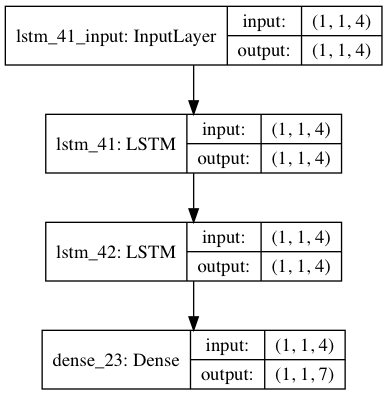

In [56]:
plot_model(agent1.model, show_shapes = True, to_file='model.png')

In [57]:
env = Second_Best_World(4, 3, 0.5)

In [59]:
# Iterate the game
episodes = 3000

for e in range(episodes):
    state1, state2, state3, _, _, _, _ = env.step(4, 4, 1, 0)
    score1 = 0
    score2 = 0
    score3 = 0
    # to store full experience traces
    experience1 = []
    experience2 = []
    experience3 = []
    actions1 = []
    actions2 = []
    actions3 = []
    prev_done = False
    for time_t in range(20):
        
        action1 = agent1.act(state1)
        action2 = agent2.act(state2)
        action3 = agent3.act(state3)

        actions1.append(action1)
        actions2.append(action2)
        actions3.append(action3)
        next_state1, next_state2, next_state3, reward1, reward2, reward3, done = env.step(action1, action2, action3, time_t)
        
        experience1.append([state1, action1, reward1, next_state1, done]) #prev_done])
        experience2.append([state2, action2, reward2, next_state2, done]) #prev_done])        
        experience3.append([state3, action3, reward3, next_state3, done]) #prev_done])        

        
        score1 += reward1
        score2 += reward2
        score3 += reward3
        
        # make next_state the new current state for the next timestep
        state1 = next_state1
        state2 = next_state2
        state3 = next_state3
        
        # break one step after the game ended
        if prev_done:
            score1 -= reward1
            score2 -= reward2
            score3 -= reward3
            break
        # done is True when the game ends
        prev_done = done
        
    # remembering weighted by the reward
    #if random.random() < (score1 + 2.2):
    agent1.remember(experience1)
    #if random.random() < (score2 + 2.2):
    agent2.remember(experience2)
    agent3.remember(experience3)
    
    agent1.model.reset_states()
    agent2.model.reset_states()
    agent3.model.reset_states()
    
    
    score1 = round(score1, 2)
    score2 = round(score2, 2)
    score3 = round(score3, 2)

    print("episode: {}/{}, score1: {}, score2: {}, score3:{}, steps: {}"
                  .format(e, episodes, score1, score2, score3, time_t))
    if len(agent1.memory) > 32 and len(agent2.memory) > 32: #and e%100 == 0:
        agent1.replay(32)
        agent2.replay(32)
    
    if len(agent3.memory) > 32:
        agent3.replay(32)
    
    a1.append(actions1)
    a2.append(actions2)
    a3.append(actions3)
    scores1.append(score1)
    scores2.append(score2)
    scores3.append(score3)

episode: 0/3000, score1: 0.49, score2: 0.99, score3:0, steps: 5
episode: 1/3000, score1: 0.99, score2: 0.99, score3:0, steps: 5
episode: 2/3000, score1: 0.49, score2: 0.49, score3:-1, steps: 4
episode: 3/3000, score1: -0.5, score2: -0.5, score3:-1, steps: 2
episode: 4/3000, score1: -0.5, score2: -0.5, score3:-1, steps: 2
episode: 5/3000, score1: -0.0, score2: -0.0, score3:-1, steps: 3
episode: 6/3000, score1: 0.99, score2: 0.99, score3:0, steps: 5
episode: 7/3000, score1: 0.99, score2: 0.99, score3:0, steps: 5
episode: 8/3000, score1: 0.99, score2: 0.99, score3:1, steps: 5
episode: 9/3000, score1: 0.99, score2: 0.99, score3:-1, steps: 5
episode: 10/3000, score1: 0.99, score2: 0.99, score3:0, steps: 5
episode: 11/3000, score1: -0.5, score2: -0.5, score3:-1, steps: 2
episode: 12/3000, score1: 0.49, score2: 0.49, score3:-1, steps: 4
episode: 13/3000, score1: 0.99, score2: 0.99, score3:0, steps: 5
episode: 14/3000, score1: -0.01, score2: -0.01, score3:-1, steps: 3
episode: 15/3000, score1:

KeyboardInterrupt: 

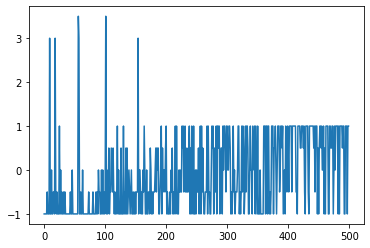

In [52]:
plt.plot(scores2)

# Without experience replay

In [59]:
class DQRNAgent_memoryless: # with hysteresis
    def __init__(self, state_size, action_size, episodes_len, obs_from_ep = 1):
        self.state_size = (1,1,state_size)
        self.action_size = action_size
        self.memory = collections.deque(maxlen=1) # no memory
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.3
        self.epsilon_decay = 0.999
        self.learning_rate_bad = 0.0001
        self.learning_rate_good = 0.1
        self.episodes_len = episodes_len
        self.obs_from_ep = obs_from_ep
        self.model = self._build_model()
        
        
    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(LSTM(4, batch_input_shape=self.state_size, return_sequences = True, stateful = True))
        model.add(LSTM(4, batch_input_shape=self.state_size, return_sequences = True, stateful = True))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='MSE',
                      optimizer=Adam(lr=self.learning_rate_bad))
        return model
    
    def remember(self, experience):
        self.memory.append((experience))
        
    def act(self, state):
        if np.random.rand() <= self.epsilon: # explore
            return random.randrange(self.action_size)
        state = np.expand_dims(state, axis=0) 
        state = np.expand_dims(state, axis=0)
        act_values = self.model.predict(state, batch_size=1)
        return np.argmax(act_values[0,0,:]) # exploit
    
    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size) #len(self.memory))
        #minibatch = [] # weighted sampling with successful games gaining more weight
        #for i in range(batch_size):
        #    while True:
        #        exp = random.choice(self.memory)
        #        if random.random() < (exp[-1][2]+2.2): # sampling 'proportional' to the reward, failed game experiences are kept at the 0.2 rate
        #            minibatch.append(exp)
        #            break
        for experience in minibatch:
            
            if len(experience) < self.episodes_len: # break if the episode is shorter than rnn seq len
                break
                
            #if len(experience)/2 >= self.episodes_len:
            #    experience = experience[math.floor(len(experience)/2):] # sample from the second half of the experiences
            
            #for first_obs_idx in range(0, len(experience)-self.episodes_len):
            for d in range(self.obs_from_ep): # several samples from sampled experience
                #first_obs_idx = random.randint(0, math.ceil((1/2)*len(experience)-self.episodes_len)) + math.floor((1/2)*len(experience)) # randomize from the last half of the experience
                first_obs_idx = random.randint(0, len(experience)-self.episodes_len)
                states = []
                targets = []
                actions = []
                for i in range(first_obs_idx, first_obs_idx+self.episodes_len):
                    #if i % 4 != 0: # every
                    #    pass
                    obs = experience[i]
                    state = obs[0]
                    action = obs[1]
                    reward = obs[2]
                    next_state = obs[3]
                    done = obs[4]
                    next_state = np.expand_dims(next_state, axis=0)
                    next_state = np.expand_dims(next_state, axis=0)
                    state = np.expand_dims(state, axis=0)
                    state = np.expand_dims(state, axis=0)
                    states.append(state)
                    actions.append(action)
                    target = reward
                        #cur_states = [current_state, next_state]
                        #cur_states = np.expand_dims(cur_states, axis = 0)
                    if not done:
                        self.model.predict(state, batch_size=1)
                        target = reward + self.gamma * np.amax(self.model.predict(next_state, batch_size=1)[0,0,:]) #check
                        self.model.reset_states()
                    targets.append(target)
                self.model.reset_states()
                for k in range(self.episodes_len):
                    target_f = self.model.predict(states[k], batch_size=1)
                    target_f[0,0,actions[k]] = targets[k]
                    if sum(target_f[0][0])>2: # won the game
                        K.set_value(self.model.optimizer.lr, self.learning_rate_good) 
                    else:
                        K.set_value(self.model.optimizer.lr, self.learning_rate_bad) 
                    self.model.fit(states[k], target_f, batch_size=1, epochs=1, verbose=0)
                self.model.reset_states() # important!
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        else:
            self.epsilon = self.epsilon_min  

In [60]:
# punishment for deciding in the first step
class Second_Best_World_2():

    # Enumeration of possible actions
    class Actions():
        a = 1
        b = 2
        c = 3
        nothing = 4
        # choose entity - entity number (the range(num of entities))

    def __init__(
        self,
        num_ent, winning_reward, talking_reward, 
        max_steps=4):

        # Action enumeration for this environment
        d = {1:"a",2:"b",3:"c",4:"nothing"}
        for i in range(num_ent):
            d[i+5] = str(i+1)
        self.actions = d
        self.num_ent = num_ent
        self.winning_reward = winning_reward
        self.talking_reward = talking_reward
        self.max_steps = max_steps
        self.talking_decay = 0.995
        self.end = False   
                
    def step(self, ag1_action, ag2_action, ag3_action, step_i, reward1 = 0, reward2 = 0, reward3 = 0):
        self.end = False
        ag3_input = np.array([random.random()]) # adversarial agent does not know anything
        
        ag1_input = np.random.normal(0,0.4,(4,))
        ag2_input = np.random.normal(0,0.4,(4,))
        
        #ag1_input[1] = random.random()
        #ag2_input[1] = random.random()
        #ag1_input[2] = random.random()
        #ag2_input[2] = random.random()
        #ag1_input[3] = random.random()
        #ag2_input[3] = random.random()
        
        ag2_action = ag2_action+1
        ag1_action = ag1_action+1
        ag3_action = ag3_action+5
        
        # agent 1 talking
        if ag1_action == 1:
            ag2_input[0] += 1
            reward1 = self.talking_decay = 0.995 * self.talking_reward
        elif ag1_action == 2:
            ag2_input[1] += 1
            reward1 = self.talking_decay = 0.995 * self.talking_reward
        elif ag1_action == 3:
            ag2_input[2] += 1
            reward1 = self.talking_decay = 0.995 * self.talking_reward
        
        #agent 2 talking
        if ag2_action == 1:
            ag1_input[0] += 1 
            reward2 = self.talking_decay = 0.995 * self.talking_reward
        elif ag2_action == 2:
            ag1_input[1] += 1 
            reward2 = self.talking_decay = 0.995 * self.talking_reward
        elif ag2_action == 3:
            ag1_input[2] += 1
            reward2 = self.talking_decay = 0.995 * self.talking_reward
        
        # agents choosing an entity?
        if ag1_action > 4 or ag2_action > 4:
            self.end = True # end the game
            if step_i == 0:
                if ag1_action > 4:
                    reward1 = -1
                    if ag1_action > 4:
                        reward2 = -1
                    else:
                        reward2 = 0
                else:
                    reward2 = -1
                    reward1 = 0
                reward3 = 0
            else:
                if ag2_action == ag1_action: 
                    if ag3_action == ag2_action: #caught in place
                        reward3 = 1
                        reward1 = -1
                        reward2 = -1
                    else:
                        reward3 = -1
                        reward1 = self.winning_reward
                        reward2 = self.winning_reward
                else:
                    reward1 = -1
                    reward2 = -1
                    if ag1_action == ag3_action or ag2_action == ag3_action:
                        reward3 = 1
                    else:
                        reward3 = -1
                            
        #end game if reached maximum number of steps 
        elif step_i >= self.max_steps:
            self.end = True
            reward1 = -1
            reward2 = -1
            reward3 = 0
        
        return(ag1_input, ag2_input, ag3_input, reward1, reward2, reward3, self.end)

In [61]:
env_size = 8
replay_exp_length = 3
replay_exp_length3 = 3

scores1 = []
scores2 = []
scores3 = []
a1 = []
a2 = []
a3 = []

agent1 = DQRNAgent_memoryless(4, 6, replay_exp_length)
agent2 = DQRNAgent_memoryless(4, 6, replay_exp_length)
agent3 = DQRNAgent_memoryless(1, 2, replay_exp_length3)


env = Second_Best_World_2(2, 3, 0.5)

In [62]:
# Iterate the game
episodes = 30

for e in range(episodes):
    state1, state2, state3, _, _, _, _ = env.step(3, 3, 1, 1)
    score1 = 0
    score2 = 0
    score3 = 0
    # to store full experience traces
    experience1 = []
    experience2 = []
    experience3 = []
    actions1 = []
    actions2 = []
    actions3 = []
    prev_done = False
    for time_t in range(20):
        
        action1 = agent1.act(state1)
        action2 = agent2.act(state2)
        action3 = agent3.act(state3)

        actions1.append(action1)
        actions2.append(action2)
        actions3.append(action3)
        next_state1, next_state2, next_state3, reward1, reward2, reward3, done = env.step(action1, action2, action3, time_t)
        
        experience1.append([state1, action1, reward1, next_state1, done]) #prev_done])
        experience2.append([state2, action2, reward2, next_state2, done]) #prev_done])        
        experience3.append([state3, action3, reward3, next_state3, done]) #prev_done])        

        
        score1 += reward1
        score2 += reward2
        score3 += reward3
        
        # make next_state the new current state for the next timestep
        state1 = next_state1
        state2 = next_state2
        state3 = next_state3
        
        # break one step after the game ended
        if prev_done:
            score1 -= reward1
            score2 -= reward2
            score3 -= reward3
            break
        # done is True when the game ends
        prev_done = done
        
    # remembering weighted by the reward
    #if random.random() < (score1 + 2.2):
    agent1.remember(experience1)
    #if random.random() < (score2 + 2.2):
    agent2.remember(experience2)
    agent3.remember(experience3)
    
    agent1.model.reset_states()
    agent2.model.reset_states()
    agent3.model.reset_states()
    
    
    score1 = round(score1, 2)
    score2 = round(score2, 2)
    score3 = round(score3, 2)

    print("episode: {}/{}, score1: {}, score2: {}, score3:{}, steps: {}"
                  .format(e, episodes, score1, score2, score3, time_t))
    if len(agent1.memory) > 0 and len(agent2.memory) > 0: #and e%100 == 0:
        agent1.replay(1)
        agent2.replay(1)
    
    if len(agent3.memory) > 0:
        agent3.replay(1)
    
    a1.append(actions1)
    a2.append(actions2)
    a3.append(actions3)
    scores1.append(score1)
    scores2.append(score2)
    scores3.append(score3)

episode: 0/30, score1: -0.5, score2: -0.5, score3:1, steps: 3


ValueError: Error when checking input: expected lstm_59_input to have shape (4, 4) but got array with shape (1, 4)

In [ ]:
plt.plot(scores1)

## One learning

In [17]:
env_size = 8
replay_exp_length = 3
replay_exp_length3 = 3

scores1 = []
scores2 = []
scores3 = []
a1 = []
a2 = []
a3 = []

agent1 = DQRNAgent_memoryless(4, 6, replay_exp_length)
agent2 = DQRNAgent_memoryless(4, 6, replay_exp_length)
agent3 = DQRNAgent_memoryless(1, 2, replay_exp_length3)


env = Second_Best_World_2(2, 3, 0.5)

In [18]:
# Iterate the game
episodes = 6000

for e in range(episodes):
    state1, state2, state3, _, _, _, _ = env.step(3, 3, 1, 1)
    score1 = 0
    score2 = 0
    score3 = 0
    # to store full experience traces
    experience1 = []
    experience2 = []
    experience3 = []
    actions1 = []
    actions2 = []
    actions3 = []
    prev_done = False
    for time_t in range(20):
        
        action1 = agent1.act(state1)
        action2 = agent2.act(state2)
        action3 = agent3.act(state3)

        actions1.append(action1)
        actions2.append(action2)
        actions3.append(action3)
        next_state1, next_state2, next_state3, reward1, reward2, reward3, done = env.step(action1, action2, action3, time_t)
        
        experience1.append([state1, action1, reward1, next_state1, done]) #prev_done])
        experience2.append([state2, action2, reward2, next_state2, done]) #prev_done])        
        experience3.append([state3, action3, reward3, next_state3, done]) #prev_done])        

        
        score1 += reward1
        score2 += reward2
        score3 += reward3
        
        # make next_state the new current state for the next timestep
        state1 = next_state1
        state2 = next_state2
        state3 = next_state3
        
        # break one step after the game ended
        if prev_done:
            score1 -= reward1
            score2 -= reward2
            score3 -= reward3
            break
        # done is True when the game ends
        prev_done = done
        
    # remembering weighted by the reward
    #if random.random() < (score1 + 2.2):
    agent1.remember(experience1)
    #if random.random() < (score2 + 2.2):
    agent2.remember(experience2)
    agent3.remember(experience3)
    
    agent1.model.reset_states()
    agent2.model.reset_states()
    agent3.model.reset_states()
    
    
    score1 = round(score1, 2)
    score2 = round(score2, 2)
    score3 = round(score3, 2)

    print("episode: {}/{}, score1: {}, score2: {}, score3:{}, steps: {}"
                  .format(e, episodes, score1, score2, score3, time_t))
    agent1.replay(1)
    if e % 50 == 0:
        agent2.replay(1) # slow learner

    agent3.replay(1)
    
    a1.append(actions1)
    a2.append(actions2)
    a3.append(actions3)
    scores1.append(score1)
    scores2.append(score2)
    scores3.append(score3)

episode: 0/6000, score1: -1, score2: -1, score3:0, steps: 1
episode: 1/6000, score1: 0, score2: -1, score3:0, steps: 1
episode: 2/6000, score1: -1.0, score2: -1.0, score3:0, steps: 1
episode: 3/6000, score1: -1.0, score2: -1, score3:0, steps: 1
episode: 4/6000, score1: -0.5, score2: -0.5, score3:1, steps: 2
episode: 5/6000, score1: -0.5, score2: -0.5, score3:1, steps: 2
episode: 6/6000, score1: -1.0, score2: -1, score3:0, steps: 1
episode: 7/6000, score1: -1, score2: -1, score3:0, steps: 1
episode: 8/6000, score1: -0.5, score2: -0.5, score3:-1, steps: 3
episode: 9/6000, score1: -0.01, score2: -0.01, score3:-1, steps: 3
episode: 10/6000, score1: 0.0, score2: -1.0, score3:0, steps: 1
episode: 11/6000, score1: -1, score2: -1, score3:0, steps: 1
episode: 12/6000, score1: -1, score2: -1, score3:0, steps: 1
episode: 13/6000, score1: 0, score2: -1, score3:0, steps: 1
episode: 14/6000, score1: -1, score2: -1.0, score3:0, steps: 1
episode: 15/6000, score1: -0.0, score2: -0.5, score3:-1, steps: 

Only one agent can talk

In [8]:
class One_Talking_Best_World():

    # Enumeration of possible actions
    class Actions():
        a = 1
        b = 2
        c = 3
        nothing = 4
        # choose entity - entity number (the range(num of entities))

    def __init__(
        self,
        num_ent, winning_reward, talking_reward, 
        max_steps=3):

        # Action enumeration for this environment
        d = {1:"a",2:"b",3:"c"}
        for i in range(num_ent):
            d[i+5] = str(i+1)
        self.actions = d
        self.num_ent = num_ent
        self.winning_reward = winning_reward
        self.talking_reward = talking_reward
        self.max_steps = max_steps
        self.talking_decay = 0.995
        self.end = False   
                
    def step(self, ag1_action, ag2_action, ag3_action, step_i, reward1 = 0, reward2 = 0, reward3 = 0):
        self.end = False
        ag3_input = np.array([random.random()]) # adversarial agent does not know anything
        ag1_input = np.array([random.random()])
        ag2_input = np.random.normal(0,0.2,(4,))
        
        ag1_action = ag1_action+1
        ag2_action = ag2_action+4
        ag3_action = ag3_action+4
        
        # agent 1 talking
        if ag1_action == 1:
            ag2_input[0] += 1
            reward1 = self.talking_decay = self.talking_reward # * 0.995
        elif ag1_action == 2:
            ag2_input[1] += 1
            reward1 = self.talking_decay = self.talking_reward # * 0.995
        elif ag1_action == 3:
            ag2_input[2] += 1
            reward1 = self.talking_decay = self.talking_reward # * 0.995
        
        if step_i>1:
            # agent 1 choosing an entity?
            if ag1_action > 4 or ag2_action > 4:
                self.end = True # end the game
                if ag2_action == ag1_action: 
                    if ag3_action == ag2_action: #caught in place
                        reward3 = 1
                        reward1 = -1
                        reward2 = -1
                    else:
                        reward3 = -1
                        reward1 = self.winning_reward
                        reward2 = self.winning_reward
                else:
                    reward1 = -1
                    reward2 = -1
                    if ag1_action == ag3_action or ag2_action == ag3_action:
                        reward3 = 1
                    else:
                        reward3 = -1
                            
        #end game if reached maximum number of steps 
        if step_i >= self.max_steps:
            self.end = True
            reward1 = -1
            reward2 = -1
            reward3 = 0
        
        return(ag1_input, ag2_input, ag3_input, reward1, reward2, reward3, self.end)

In [56]:
# Deep Q-learning Agent with histeresis
class DQRNAgent_optimistic:
    def __init__(self, state_size, action_size, episodes_len, obs_from_ep = 1):
        self.state_size = (1,1,state_size) # 4 timesteps
        self.action_size = action_size
        self.memory = collections.deque(maxlen=40)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.1
        self.epsilon_decay = 0.995
        self.learning_rate_good = 0.1
        self.learning_rate_bad = 0.001
        self.episodes_len = episodes_len
        self.obs_from_ep = obs_from_ep
        self.model = self._build_model()
        
        
    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(LSTM(4, batch_input_shape=self.state_size, return_sequences = True, stateful = True))
        model.add(LSTM(4, batch_input_shape=self.state_size, return_sequences = True, stateful = True))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='MSE',
                      optimizer=Adam(lr=self.learning_rate_bad))
        return model
    
    def remember(self, experience):
        self.memory.append((experience))
        
    def act(self, state):
        if np.random.rand() <= self.epsilon: # explore
            return random.randrange(self.action_size)
        state = np.expand_dims(state, axis=0) 
        state = np.expand_dims(state, axis=0)
        act_values = self.model.predict(state, batch_size=1)
        return np.argmax(act_values[0,0,:]) # exploit
    
    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size) #len(self.memory))
        #minibatch = [] # weighted sampling with successful games gaining more weight
        #for i in range(batch_size):
        #    while True:
        #        exp = random.choice(self.memory)
        #        if random.random() < (exp[-1][2]+2.2): # sampling 'proportional' to the reward, failed game experiences are kept at the 0.2 rate
        #            minibatch.append(exp)
        #            break
        
        for experience in minibatch:
            
            if len(experience) < self.episodes_len: # break if the episode is shorter than rnn seq len
                break
                
            #if len(experience)/2 >= self.episodes_len:
            #    experience = experience[math.floor(len(experience)/2):] # sample from the second half of the experiences
            
            #for first_obs_idx in range(0, len(experience)-self.episodes_len):
            for d in range(self.obs_from_ep): # several samples from sampled experience
                #first_obs_idx = random.randint(0, math.ceil((1/2)*len(experience)-self.episodes_len)) + math.floor((1/2)*len(experience)) # randomize from the last half of the experience
                first_obs_idx = random.randint(0, len(experience)-self.episodes_len)
                states = []
                targets = []
                actions = []
                for i in range(first_obs_idx, first_obs_idx+self.episodes_len):
                    #if i % 4 != 0: # every
                    #    pass
                    obs = experience[i]
                    state = obs[0]
                    action = obs[1]
                    reward = obs[2]
                    next_state = obs[3]
                    done = obs[4]
                    next_state = np.expand_dims(next_state, axis=0)
                    next_state = np.expand_dims(next_state, axis=0)
                    state = np.expand_dims(state, axis=0)
                    state = np.expand_dims(state, axis=0)
                    states.append(state)
                    actions.append(action)
                    target = reward
                        #cur_states = [current_state, next_state]
                        #cur_states = np.expand_dims(cur_states, axis = 0)
                    if not done:
                        self.model.predict(state, batch_size=1)
                        target = reward + self.gamma * np.amax(self.model.predict(next_state, batch_size=1)[0,0,:]) #check
                        self.model.reset_states()
                    targets.append(target)
                self.model.reset_states()
                for k in range(self.episodes_len):
                    target_f = self.model.predict(states[k], batch_size=1)
                    target_f[0,0,actions[k]] = targets[k]
                    if sum(target_f[0][0])>2:
                        K.set_value(self.model.optimizer.lr, self.learning_rate_good) 
                    else:
                        K.set_value(self.model.optimizer.lr, self.learning_rate_bad) 
                    self.model.fit(states[k], target_f, batch_size=1, epochs=1, verbose=0)
                self.model.reset_states() # important!
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        else:
            self.epsilon = self.epsilon_min  

In [57]:
env_size = 8
replay_exp_length = 3
replay_exp_length3 = 3

scores1 = []
scores2 = []
scores3 = []
a1 = []
a2 = []
a3 = []

agent1 = DQRNAgent_optimistic(1, 7, replay_exp_length) # can talk
agent2 = DQRNAgent_optimistic(4, 4, replay_exp_length) # receive talkings
agent3 = DQRNAgent_optimistic(1, 4, replay_exp_length3)

In [58]:
env = One_Talking_Best_World(3, 3, 0.5)

NameError: name 'One_Talking_Best_World' is not defined

In [ ]:
# Iterate the game
episodes = 1000

for e in range(episodes):
    state1, state2, state3, _, _, _, _ = env.step(4, 4, 1, 0)
    score1 = 0
    score2 = 0
    score3 = 0
    # to store full experience traces
    experience1 = []
    experience2 = []
    experience3 = []
    actions1 = []
    actions2 = []
    actions3 = []
    prev_done = False
    for time_t in range(5):
        
        action1 = agent1.act(state1)
        action2 = agent2.act(state2)
        action3 = agent3.act(state3)

        actions1.append(action1)
        actions2.append(action2)
        actions3.append(action3)
        next_state1, next_state2, next_state3, reward1, reward2, reward3, done = env.step(action1, action2, action3, time_t)
        
        experience1.append([state1, action1, reward1, next_state1, done]) #prev_done])
        experience2.append([state2, action2, reward2, next_state2, done]) #prev_done])        
        experience3.append([state3, action3, reward3, next_state3, done]) #prev_done])        
        
        score1 += reward1
        score2 += reward2
        score3 += reward3
        
        # make next_state the new current state for the next timestep
        state1 = next_state1
        state2 = next_state2
        state3 = next_state3
        
        # break one step after the game ended
        if prev_done:
            score1 -= reward1
            score2 -= reward2
            score3 -= reward3
            break
        # done is True when the game ends
        prev_done = done
        
    # remembering weighted by the reward
    #if random.random() < (score1 + 2.2):
    agent1.remember(experience1)
    #if random.random() < (score2 + 2.2):
    agent2.remember(experience2)
    agent3.remember(experience3)
    
    agent1.model.reset_states()
    agent2.model.reset_states()
    agent3.model.reset_states()
    
    
    score1 = round(score1, 2)
    score2 = round(score2, 2)
    score3 = round(score3, 2)

    print("episode: {}/{}, score1: {}, score2: {}, score3:{}, steps: {}"
                  .format(e, episodes, score1, score2, score3, time_t))
    if len(agent1.memory) > 32 and len(agent2.memory) > 32: 
        agent1.replay(32)
        agent2.replay(32)
    
    if len(agent3.memory) > 32:
        agent3.replay(32)
    
    a1.append(actions1)
    a2.append(actions2)
    a3.append(actions3)
    scores1.append(score1)
    scores2.append(score2)
    scores3.append(score3)

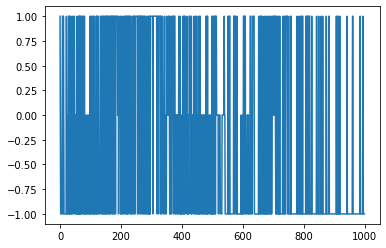

In [172]:
plt.plot(scores3)

## Predictive agents

In [70]:
# Deep Q-learning Agent with histeresis
class DQRNAgent_predictive:
    def __init__(self, state_size, action_size, episodes_len, obs_from_ep = 1):
        self.state_size = (1,1,state_size)
        self.action_size = action_size
        self.memory = collections.deque(maxlen=40)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.1
        self.epsilon_decay = 0.995
        self.learning_rate_good = 0.1
        self.learning_rate_bad = 0.001
        self.episodes_len = episodes_len
        self.obs_from_ep = obs_from_ep
        self.model = self._build_model()        
        
    def _build_model(self):         # predictive RNN + Q-learning
        input_state = Input(batch_shape=state_size)

        x = input_state
        x = LSTM(4, return_sequences = True, stateful = True)(x)
        predict_next = Dense(self.state_size[2], name='predict_next')(x)
        predictor = Model(input_state, predict_next, name='predictor')
        
        predictive_input = Input(batch_shape=self.state_size, name='predictive_input')
        predictive_state = predictive_input
        input_full_state = concatenate([predictive_input, input_state], axis=2)
        
        y = input_full_state
        y = LSTM(4, return_sequences = True, stateful = True)(y)
        out_action = Dense(self.action_size, activation='linear', name='Q-values')(y)

        actor = Model([predictive_input, input_state], [predictive_state, out_action], name='actor') 
        outputs = actor([predictor(input_state), input_state])
        actor_predictor = Model(input_state, outputs, name='actor_predictor')
        
        
        actor_predictor.compile(loss={'actor': 'MSE', 'actor': 'MSE'}, #first is predictive, second - Q-values
              #loss_weights={'classification': 1.0,
              #              'autoencoder': 0.5},
              optimizer=Adam(lr=self.learning_rate_bad))

        return actor_predictor
    
    def remember(self, experience):
        self.memory.append((experience))
        
    def act(self, state):
        if np.random.rand() <= self.epsilon: # explore
            return random.randrange(self.action_size)
        state = np.expand_dims(state, axis=0) 
        state = np.expand_dims(state, axis=0)
        act_values = self.model.predict(state, batch_size=1)
        return np.argmax(act_values[0,0,:]) # exploit
    
    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size) #len(self.memory))
        #for i in range(batch_size):
        #    while True:
        #        exp = random.choice(self.memory)
        #        if random.random() < (exp[-1][2]+2.2): # sampling 'proportional' to the reward, failed game experiences are kept at the 0.2 rate
        #            minibatch.append(exp)
        #            break
        
        for experience in minibatch:
            
            if len(experience) < self.episodes_len: # break if the episode is shorter than rnn seq len
                break
                
            #if len(experience)/2 >= self.episodes_len:
            #    experience = experience[math.floor(len(experience)/2):] # sample from the second half of the experiences
            
            #for first_obs_idx in range(0, len(experience)-self.episodes_len):
            for d in range(self.obs_from_ep): # several samples from sampled experience
                #first_obs_idx = random.randint(0, math.ceil((1/2)*len(experience)-self.episodes_len)) + math.floor((1/2)*len(experience)) # randomize from the last half of the experience
                first_obs_idx = random.randint(0, len(experience)-self.episodes_len)
                states = []
                targets = []
                actions = []
                for i in range(first_obs_idx, first_obs_idx+self.episodes_len):
                    #if i % 4 != 0: # every
                    #    pass
                    obs = experience[i]
                    state = obs[0]
                    action = obs[1]
                    reward = obs[2]
                    next_state = obs[3]
                    done = obs[4]
                    next_state = np.expand_dims(next_state, axis=0)
                    next_state = np.expand_dims(next_state, axis=0)
                    state = np.expand_dims(state, axis=0)
                    state = np.expand_dims(state, axis=0)
                    states.append(state)
                    actions.append(action)
                    target = reward
                        #cur_states = [current_state, next_state]
                        #cur_states = np.expand_dims(cur_states, axis = 0)
                    if not done:
                        print(state)
                        print(state.shape)
                        self.model.predict(state, batch_size=1)
                        target = reward + self.gamma * np.amax(self.model.predict(next_state, batch_size=1)[0,0,:]) #check
                        self.model.reset_states()
                    targets.append(target)
                self.model.reset_states()
                for k in range(self.episodes_len):
                    target_f = self.model.predict(states[k], batch_size=1, workers=0)
                    print(target_f)
                    print(target_f.shape)
                    target_f[0,0,actions[k]] = targets[k]
                    self.model.fit(states[k], {'actor': states[k], 'actor': target_f}, batch_size=1, epochs=1, verbose=0)
                self.model.reset_states() # important!
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        else:
            self.epsilon = self.epsilon_min  

Predictive: WORKING

In [141]:
# Deep Q-learning Agent with histeresis
class DQRNAgent_predictive:
    def __init__(self, state_size, action_size, episodes_len, obs_from_ep = 1):
        self.state_size = (1,1,state_size)
        self.action_size = action_size
        self.memory = collections.deque(maxlen=1)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.3
        self.epsilon_decay = 0.995
        self.learning_rate_good = 0.01
        self.learning_rate_bad = 0.001
        self.episodes_len = episodes_len
        self.obs_from_ep = obs_from_ep
        self.model = self._build_model()        
        
    def _build_model(self):         # predictive RNN + Q-learning
        input_state = Input(batch_shape=state_size)

        x = input_state
        x = LSTM(12, return_sequences = True, stateful = True)(x)
        x = Dense(6, activation = "relu")(x)
        predict_next = Dense(self.state_size[2], name='predict_next')(x)
        
        x = concatenate([predict_next, input_state], axis=2)        
        
        x = LSTM(12, return_sequences = True, stateful = True)(x)
        x = LSTM(4, return_sequences = True, stateful = True)(x)
        x = Dense(4, activation = "relu")(x)
        out_action = Dense(self.action_size, activation='linear', name='Q-values')(x)

        actor = Model([input_state], [predict_next, out_action], name='actor')        
        
        actor.compile(loss={'predict_next': 'MSE', 'Q-values': 'MSE'}, #first is predictive, second - Q-values
              #loss_weights={'classification': 1.0,
              #              'autoencoder': 0.5},
              optimizer=Adam(lr=self.learning_rate_bad))

        return actor
    
    def remember(self, experience):
        self.memory.append((experience))
        
    def act(self, state):
        if np.random.rand() <= self.epsilon: # explore
            return random.randrange(self.action_size)
        state = np.expand_dims(state, axis=0) 
        state = np.expand_dims(state, axis=0)
        act_values = self.model.predict(state, batch_size=1)[1]
        return np.argmax(act_values[0,0,:]) # exploit
    
    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size) #len(self.memory))
        #for i in range(batch_size):
        #    while True:
        #        exp = random.choice(self.memory)
        #        if random.random() < (exp[-1][2]+2.2): # sampling 'proportional' to the reward, failed game experiences are kept at the 0.2 rate
        #            minibatch.append(exp)
        #            break
        
        for experience in minibatch:
            
            if len(experience) < self.episodes_len: # break if the episode is shorter than rnn seq len
                break
                
            #if len(experience)/2 >= self.episodes_len:
            #    experience = experience[math.floor(len(experience)/2):] # sample from the second half of the experiences
            
            #for first_obs_idx in range(0, len(experience)-self.episodes_len):
            for d in range(self.obs_from_ep): # several samples from sampled experience
                #first_obs_idx = random.randint(0, math.ceil((1/2)*len(experience)-self.episodes_len)) + math.floor((1/2)*len(experience)) # randomize from the last half of the experience
                first_obs_idx = random.randint(0, len(experience)-self.episodes_len)
                states = []
                targets = []
                actions = []
                for i in range(first_obs_idx, first_obs_idx+self.episodes_len):
                    #if i % 4 != 0: # every
                    #    pass
                    obs = experience[i]
                    state = obs[0]
                    action = obs[1]
                    reward = obs[2]
                    next_state = obs[3]
                    done = obs[4]
                    next_state = np.expand_dims(next_state, axis=0)
                    next_state = np.expand_dims(next_state, axis=0)
                    state = np.expand_dims(state, axis=0)
                    state = np.expand_dims(state, axis=0)
                    states.append(state)
                    actions.append(action)
                    target = reward
                        #cur_states = [current_state, next_state]
                        #cur_states = np.expand_dims(cur_states, axis = 0)
                    if not done:
                        self.model.predict(state, batch_size=1)
                        target = reward + self.gamma * np.amax(self.model.predict(next_state, batch_size=1)[1][0,0,:]) #check
                        self.model.reset_states()
                    targets.append(target)
                self.model.reset_states()
                for k in range(self.episodes_len):
                    target_f = self.model.predict(states[k], batch_size=1)[1]
                    target_f[0,0,actions[k]] = targets[k]
                    if sum(target_f[0][0])>2:
                        K.set_value(self.model.optimizer.lr, self.learning_rate_good) 
                    else:
                        K.set_value(self.model.optimizer.lr, self.learning_rate_bad) 
                    self.model.fit(states[k], {'predict_next': states[k], 'Q-values': target_f}, batch_size=1, epochs=1, verbose=0)
                self.model.reset_states() # important!
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        else:
            self.epsilon = self.epsilon_min  

In [142]:
env_size = 8
replay_exp_length = 3
replay_exp_length3 = 3

scores1 = []
scores2 = []
scores3 = []
a1 = []
a2 = []
a3 = []

agent1 = DQRNAgent_predictive(4, 7, replay_exp_length) # can talk
agent2 = DQRNAgent_predictive(4, 7, replay_exp_length) # receive talkings
agent3 = DQRNAgent(1, 4, replay_exp_length3)

In [143]:
env = Second_Best_World(4, 3, 0.5)

In [144]:
# Iterate the game
episodes = 5000

for e in range(episodes):
    state1, state2, state3, _, _, _, _ = env.step(4, 4, 1, 0)
    score1 = 0
    score2 = 0
    score3 = 0
    # to store full experience traces
    experience1 = []
    experience2 = []
    experience3 = []
    actions1 = []
    actions2 = []
    actions3 = []
    prev_done = False
    for time_t in range(5):
        
        action1 = agent1.act(state1)
        action2 = agent2.act(state2)
        action3 = agent3.act(state3)

        actions1.append(action1)
        actions2.append(action2)
        actions3.append(action3)
        next_state1, next_state2, next_state3, reward1, reward2, reward3, done = env.step(action1, action2, action3, time_t)
        
        experience1.append([state1, action1, reward1, next_state1, done]) #prev_done])
        experience2.append([state2, action2, reward2, next_state2, done]) #prev_done])        
        experience3.append([state3, action3, reward3, next_state3, done]) #prev_done])        
        
        score1 += reward1
        score2 += reward2
        score3 += reward3
        
        # make next_state the new current state for the next timestep
        state1 = next_state1
        state2 = next_state2
        state3 = next_state3
        
        # break one step after the game ended
        if prev_done:
            score1 -= reward1
            score2 -= reward2
            score3 -= reward3
            break
        # done is True when the game ends
        prev_done = done
        
    # remembering weighted by the reward
    #if random.random() < (score1 + 2.2):
    agent1.remember(experience1)
    #if random.random() < (score2 + 2.2):
    agent2.remember(experience2)
    agent3.remember(experience3)
    
    agent1.model.reset_states()
    agent2.model.reset_states()
    agent3.model.reset_states()
    
    
    score1 = round(score1, 2)
    score2 = round(score2, 2)
    score3 = round(score3, 2)

    print("episode: {}/{}, score1: {}, score2: {}, score3:{}, steps: {}"
                  .format(e, episodes, score1, score2, score3, time_t))
    if len(agent1.memory) > 32 and len(agent2.memory) > 32: 
        agent1.replay(1)
        agent2.replay(1)
    
    if len(agent3.memory) > 32:
        agent3.replay(1)
    
    a1.append(actions1)
    a2.append(actions2)
    a3.append(actions3)
    scores1.append(score1)
    scores2.append(score2)
    scores3.append(score3)

episode: 0/5000, score1: -1, score2: -1, score3:-1, steps: 1
episode: 1/5000, score1: -1, score2: -1, score3:-1, steps: 1
episode: 2/5000, score1: -1.0, score2: -1.0, score3:1, steps: 1
episode: 3/5000, score1: -1, score2: -1, score3:-1, steps: 1
episode: 4/5000, score1: -1, score2: -1, score3:-1, steps: 1
episode: 5/5000, score1: -1, score2: -1, score3:-1, steps: 1
episode: 6/5000, score1: -1, score2: -1, score3:-1, steps: 1
episode: 7/5000, score1: -1.0, score2: -1.0, score3:-1, steps: 1
episode: 8/5000, score1: 4.0, score2: 4.49, score3:-1, steps: 4
episode: 9/5000, score1: -1.0, score2: -1.0, score3:-1, steps: 1
episode: 10/5000, score1: -1, score2: -1, score3:-1, steps: 1
episode: 11/5000, score1: -0.5, score2: 0.49, score3:1, steps: 4
episode: 12/5000, score1: -0.5, score2: -0.5, score3:-1, steps: 2
episode: 13/5000, score1: -1, score2: -1, score3:1, steps: 1
episode: 14/5000, score1: -0.5, score2: -0.5, score3:-1, steps: 2
episode: 15/5000, score1: -1, score2: -1, score3:1, step

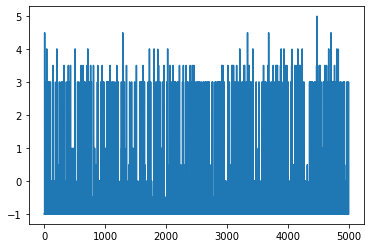

In [145]:
plt.plot(scores2)

# No time + one agent talks

In [456]:
class One_Talking_No_Time_Best_World():

    # Enumeration of possible actions
    class Actions():
        silence = 0
        a = 1
        b = 2
        c = 3
        nothing = 4
        choose_1 = 5
        choose_2 = 6
        choose_3 = 7 #etc
        # choose entity - entity number (the range(num of entities))

    def __init__(
        self, num_ent, winning_reward, talking_reward = 0): #choose true or false

        # Action enumeration for this environment
        d = {1:"a",2:"b",3:"c"}
        for i in range(num_ent):
            d[i+4] = str(i+1)
        self.actions = d
        self.num_ent = num_ent
        self.winning_reward = winning_reward
        self.talking_reward = talking_reward
        self.talking_decay = 0.995
                
    def step(self, ag1_action, ag2_action, ag3_action, choose, reward1 = 0, reward2 = 0, reward3 = 0):
        ag3_input = np.array([random.random()]) # adversarial agent does not know anything
        ag1_input = np.array([np.random.beta(0.5,0.5)]) #UNIFORM/bimodal NOISE
        ag2_input = np.random.normal(0,0.1,(4,)) #talking binary (3) + noise
                
        if choose: # step of choice
            if ag2_action == ag1_action: 
                if ag3_action == ag2_action: #caught in place
                    reward3 = 1
                    reward1 = -1
                    reward2 = -1
                else:
                    reward3 = -1
                    reward1 = self.winning_reward
                    reward2 = self.winning_reward
            else:
                reward1 = -1
                reward2 = -1
                if ag1_action == ag3_action or ag2_action == ag3_action:
                    reward3 = 1
                else:
                    reward3 = -1
                    
        else: # agent 1 talking 
            if ag1_action == 1:
                ag2_input[0] += 1
                reward1 = self.talking_reward # * 0.995
            elif ag1_action == 2:
                ag2_input[1] += 1
                reward1 = self.talking_reward # * 0.995
            elif ag1_action == 3:
                ag2_input[2] += 1
                reward1 = self.talking_reward # * 0.995
        
        return(ag1_input, ag2_input, ag3_input, reward1, reward2, reward3)

In [466]:
# Deep Q-learning Agent
class DQNAgent_2:
    def __init__(self, state_size, talking_action_size, choices):
        self.state_size = state_size
        self.memory = collections.deque(maxlen=100)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.3
        self.epsilon_decay = 0.999
        self.learning_rate_bad = 0.0001
        self.learning_rate_good = 0.01

        self.talking_action_size = talking_action_size
        self.choices = choices
        self.model = self._build_model()

    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        t = 0
        model = Sequential()
        model.add(Dense(3, input_dim=self.state_size, activation='relu'))
        model.add(Dense(3, activation='relu'))
        if self.talking_action_size > 0:
            t = 1 # nothing for talking
        model.add(Dense(self.talking_action_size + t + self.choices + 1, activation='linear'))
        model.compile(loss='mse',
                      optimizer=Adam(lr=self.learning_rate_bad))
        return model
    
    def remember(self, state, action, reward, next_state):
        self.memory.append((state, action, reward, next_state))
                           
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            if self.talking_action_size == 0:
                return random.randrange(self.choices+1)
            else:
                return [random.randrange(self.talking_action_size+1), random.randrange(self.choices+1)]
        state = np.expand_dims(state, axis=0)
        act_values = self.model.predict(state, batch_size=1)
        if self.talking_action_size == 0:
            return np.argmax(act_values[0])  # returns choice from 0 to n-1
        else:
            talk = np.argmax(act_values[0][:self.talking_action_size+1])
            choice = np.argmax(act_values[0][self.talking_action_size+1:]) # returns choice from 0 to n-1
            return [talk, choice]
                           
    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state in minibatch:
            next_state = np.expand_dims(next_state, axis=0)
            state = np.expand_dims(state, axis=0)
            target = reward
            if target>2: # won the game
                K.set_value(self.model.optimizer.lr, self.learning_rate_good) 
            else:
                K.set_value(self.model.optimizer.lr, self.learning_rate_bad)
            if self.talking_action_size == 0:
            #if not done:
            #    target = reward + self.gamma * np.amax(self.model.predict(next_state, batch_size=1)[0])
                target_f = self.model.predict(state, batch_size=1)
                target_f[0][action] = target
                self.model.fit(state, target_f, batch_size=1, epochs=1, verbose=0)
            else:
                target_f = self.model.predict(state, batch_size=1)
                target_f[0][action[0]] = target # talk
                target_f[0][action[1]+self.talking_action_size+1] = target # choose
                self.model.fit(state, target_f, batch_size=1, epochs=1, verbose=0)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [467]:
agent1 = DQNAgent_2(1, 3, 3) # can talk
agent2 = DQNAgent_2(4, 0, 3) # receives talkings
agent3 = DQNAgent_2(1, 0, 3)

In [468]:
env = One_Talking_No_Time_Best_World(3, 3, 0)

In [469]:
# Iterate the game
episodes = 1500
a1_talk = []
a1_act = []
a2 = []
a3 = []
scores1 = []
scores2 = []
scores3 = []

wins = 1
loses = 1

for e in range(episodes):
    score1 = 0
    score2 = 0
    score3 = 0
    
    state1, state2, state3, _, _, _ = env.step(0, 0, 1, 0) # 4 - doing nothing 
    
    # agent 1 talks
    action1 = agent1.act(state1)
    
    state1, state2, state3, reward1, reward2, reward3 = env.step(action1[0], 4, 1, 0)     
    score1 += reward1
    
    action2 = agent2.act(state2)
    action3 = agent3.act(state3)
    
    # everyone chooses
    next_state1, next_state2, next_state3, reward1, reward2, reward3 = env.step(action1[1], action2, action3, 1)     
        
    score1 += reward1
    score2 += reward2
    score3 += reward3
    if reward1 > 2: #won the game
        wins += 1
    else:
        loses += 1
        
    # remembering weighted by the reward
    #if random.random() < (score1 + 2.2):
    agent2.remember(state2, action2, reward2, next_state2)
    agent1.remember(state1, action1, reward1, next_state1)
    agent3.remember(state3, action3, reward3, next_state3)


    print("episode: {}/{}, score1: {}, score2: {}, score3:{}"
                  .format(e, episodes, score1, score2, score3))
    if len(agent1.memory) > 10 and len(agent2.memory) > 10: 
        if wins/loses < np.random.uniform(0,2):   
            agent1.replay(10)
            agent2.replay(10)
    
    if len(agent3.memory) > 10:
        agent3.replay(10)
    
    a1_talk.append(action1[0])
    a1_act.append(action1[1])
    a2.append(action2)
    a3.append(action3)
    scores1.append(score1)
    scores2.append(score2)
    scores3.append(score3)

episode: 0/1500, score1: -1, score2: -1, score3:1
episode: 1/1500, score1: -1, score2: -1, score3:1
episode: 2/1500, score1: -1, score2: -1, score3:-1
episode: 3/1500, score1: -1, score2: -1, score3:1
episode: 4/1500, score1: -1, score2: -1, score3:1
episode: 5/1500, score1: -1, score2: -1, score3:1
episode: 6/1500, score1: -1, score2: -1, score3:-1
episode: 7/1500, score1: -1, score2: -1, score3:-1
episode: 8/1500, score1: -1, score2: -1, score3:-1
episode: 9/1500, score1: -1, score2: -1, score3:-1
episode: 10/1500, score1: -1, score2: -1, score3:1
episode: 11/1500, score1: -1, score2: -1, score3:-1
episode: 12/1500, score1: -1, score2: -1, score3:-1
episode: 13/1500, score1: -1, score2: -1, score3:1
episode: 14/1500, score1: -1, score2: -1, score3:-1
episode: 15/1500, score1: -1, score2: -1, score3:-1
episode: 16/1500, score1: -1, score2: -1, score3:1
episode: 17/1500, score1: -1, score2: -1, score3:-1
episode: 18/1500, score1: -1, score2: -1, score3:-1
episode: 19/1500, score1: -1, 

In [470]:
scores1 = np.array(scores1)
a1_talk = np.array(a1_talk)
a1_act = np.array(a1_act)
a2 = np.array(a2)

(array([  8.,   0.,   0.,   8.,   0.,   0., 146.,   0.,   0.,  26.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

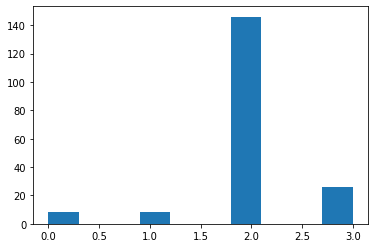

In [471]:
plt.hist(a1_talk[1000:][scores1[1000:] == 3])

(array([224.,   0.,   0., 202.,   0.,   0., 540.,   0.,   0., 534.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

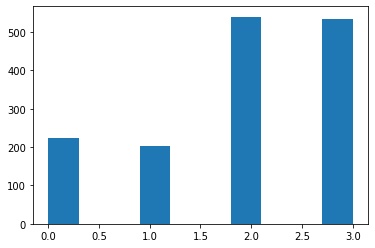

In [472]:
plt.hist(a1_talk)

(array([54.,  0.,  0., 42.,  0.,  0., 75.,  0.,  0., 53.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

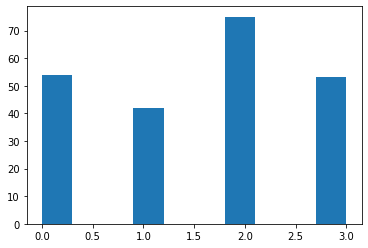

In [477]:
plt.hist(a1_act[:][a1_talk[:] == 0])

(array([36.,  0.,  0., 41.,  0.,  0., 86.,  0.,  0., 61.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

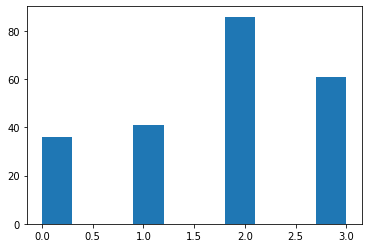

In [479]:
plt.hist(a2[:][a1_talk[:] == 0])

## Memorizing all (sparse) positive rewards

In [396]:
#agent1 gets inputs from bimodal distribution + punishment increase
class One_Talking_No_Time_Best_World():

    # Enumeration of possible actions
    class Actions():
        silence = 0
        a = 1
        b = 2
        c = 3
        nothing = 4
        choose_1 = 5
        choose_2 = 6
        choose_3 = 7 #etc
        # choose entity - entity number (the range(num of entities))

    def __init__(
        self, num_ent, winning_reward, talking_reward = 0): #choose true or false

        # Action enumeration for this environment
        d = {1:"a",2:"b",3:"c"}
        for i in range(num_ent):
            d[i+4] = str(i+1)
        self.actions = d
        self.num_ent = num_ent
        self.winning_reward = winning_reward
        self.talking_reward = talking_reward
        self.beta_punishment = 1
        self.punishment = -1
        self.talking_decay = 0.995
                
    def step(self, ag1_action, ag2_action, ag3_action, choose, reward1 = 0, reward2 = 0, reward3 = 0):
        ag3_input = np.array([random.random()]) # adversarial agent does not know anything
        ag1_input = np.array([np.random.beta(0.5,0.5)]) #bimodal
        ag2_input = np.random.normal(0,0.1,(4,)) #talking binary (3) + noise
                
        if choose: # step of choice
            if ag2_action == ag1_action: 
                self.punishment = self.beta_punishment * self.punishment # punishment change
                if ag3_action == ag2_action: #caught in place
                    reward3 = 1
                    reward1 = self.punishment
                    reward2 = self.punishment
                else:
                    reward3 = -1
                    reward1 = self.winning_reward
                    reward2 = self.winning_reward
            else:
                reward1 = self.punishment
                reward2 = self.punishment
                if ag1_action == ag3_action or ag2_action == ag3_action:
                    reward3 = 1
                else:
                    reward3 = -1
                    
        else: # agent 1 talking 
            if ag1_action == 1:
                ag2_input[0] += 1
                reward1 = self.talking_reward # * 0.995
            elif ag1_action == 2:
                ag2_input[1] += 1
                reward1 = self.talking_reward # * 0.995
            elif ag1_action == 3:
                ag2_input[2] += 1
                reward1 = self.talking_reward # * 0.995
        
        return(ag1_input, ag2_input, ag3_input, reward1, reward2, reward3)

In [397]:
env = One_Talking_No_Time_Best_World(3, 3, 0)

In [398]:
# Deep Q-learning Agent
class DQNAgent_2_optim_memory:
    def __init__(self, state_size, talking_action_size, choices):
        self.state_size = state_size
        self.opt_memory = collections.deque(maxlen=20)
        self.memory = collections.deque(maxlen=1)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.1
        self.epsilon_decay = 0.9999
        self.learning_rate_bad = 0.001
        self.learning_rate_good = 0.001

        self.talking_action_size = talking_action_size
        self.choices = choices
        self.model = self._build_model()

    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        t = 0
        model = Sequential()
        model.add(Dense(2, input_dim=self.state_size, activation='relu'))
        model.add(Dense(2, activation='relu'))
        if self.talking_action_size > 0:
            t = 1 # nothing for talking
        model.add(Dense(self.talking_action_size + self.choices + 1 + t, activation='linear'))
        model.compile(loss='mse',
                      optimizer=Adam(lr=self.learning_rate_bad))
        return model
    
    def remember(self, state, action, reward, next_state):
        if reward > 2:
            self.opt_memory.append((state, action, reward, next_state))
        else:
            self.memory.append((state, action, reward, next_state))
                           
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            if self.talking_action_size == 0:
                return random.randrange(self.choices+1)
            else:
                return [random.randrange(self.talking_action_size+1), random.randrange(self.choices+1)]
        state = np.expand_dims(state, axis=0)
        act_values = self.model.predict(state, batch_size=1)
        if self.talking_action_size == 0:
            return np.argmax(act_values[0])  # returns choice from 0 to n-1
        else:
            talk = np.argmax(act_values[0][:self.talking_action_size+1])
            choice = np.argmax(act_values[0][self.talking_action_size+1:]) # returns choice from 0 to n-1
            return [talk, choice]
                           
    def replay(self, batch_size, memory_type):
        if memory_type == "normal":
            minibatch = random.sample(self.memory, batch_size)
        elif memory_type == "optimistic":
            minibatch = random.sample(self.opt_memory, batch_size)
        for state, action, reward, next_state in minibatch:
            next_state = np.expand_dims(next_state, axis=0)
            state = np.expand_dims(state, axis=0)
            target = reward
            if target>2: # won the game
                K.set_value(self.model.optimizer.lr, self.learning_rate_good) 
            else:
                K.set_value(self.model.optimizer.lr, self.learning_rate_bad)
            if self.talking_action_size == 0:
            #if not done:
            #    target = reward + self.gamma * np.amax(self.model.predict(next_state, batch_size=1)[0])
                target_f = self.model.predict(state, batch_size=1)
                target_f[0][action] = target
                self.model.fit(state, target_f, batch_size=1, epochs=1, verbose=0)
            else:
                target_f = self.model.predict(state, batch_size=1)
                target_f[0][action[0]] = target # talk
                target_f[0][action[1]+self.talking_action_size+1] = target # choose
                self.model.fit(state, target_f, batch_size=1, epochs=1, verbose=0)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [399]:
agent1 = DQNAgent_2_optim_memory(1, 3, 3) # can talk
agent2 = DQNAgent_2_optim_memory(4, 0, 3) # receive talkings
agent3 = DQNAgent_2_optim_memory(1, 0, 3)

In [400]:
# Iterate the game
episodes = 5000
a1_talk = []
a1_act = []
a2 = []
a3 = []
scores1 = []
scores2 = []
scores3 = []

for e in range(episodes):
    score1 = 0
    score2 = 0
    score3 = 0
    
    state1, state2, state3, _, _, _ = env.step(0, 0, 1, 0) # 4 - doing nothing 
    
    # agent 1 talks
    action1 = agent1.act(state1)
    
    state1, state2, state3, reward1, reward2, reward3 = env.step(action1[0], 4, 1, 0)     
    score1 += reward1
    
    action2 = agent2.act(state2)
    action3 = agent3.act(state3)
    
    # everyone chooses
    next_state1, next_state2, next_state3, reward1, reward2, reward3 = env.step(action1[1], action2, action3, 1)     
        
    score1 += reward1
    score2 += reward2
    score3 += reward3
        
    # remembering weighted by the reward
    #if random.random() < (score1 + 2.2):
    agent2.remember(state2, action2, reward2, next_state2)
    agent1.remember(state1, action1, reward1, next_state1)
    agent3.remember(state3, action3, reward3, next_state3)


    print("episode: {}/{}, score1: {}, score2: {}, score3:{}"
                  .format(e, episodes, score1, score2, score3))
    if len(agent1.opt_memory) > 10 and len(agent2.opt_memory) > 10: 
        agent1.replay(5, "optimistic")
        agent2.replay(5, "optimistic")
    
    agent3.replay(1, "normal")
    if len(agent1.memory) > 1:
        agent2.replay(1, "normal")
        agent1.replay(1, "normal")
    
    a1_talk.append(action1[0])
    a1_act.append(action1[1])
    a2.append(action2)
    a3.append(action3)
    scores1.append(score1)
    scores2.append(score2)
    scores3.append(score3)

episode: 0/5000, score1: -1, score2: -1, score3:-1
episode: 1/5000, score1: 3, score2: 3, score3:-1
episode: 2/5000, score1: -1, score2: -1, score3:1
episode: 3/5000, score1: 3, score2: 3, score3:-1
episode: 4/5000, score1: 3, score2: 3, score3:-1
episode: 5/5000, score1: -1, score2: -1, score3:1
episode: 6/5000, score1: 3, score2: 3, score3:-1
episode: 7/5000, score1: -1, score2: -1, score3:-1
episode: 8/5000, score1: 3, score2: 3, score3:-1
episode: 9/5000, score1: -1, score2: -1, score3:-1
episode: 10/5000, score1: 3, score2: 3, score3:-1
episode: 11/5000, score1: 3, score2: 3, score3:-1
episode: 12/5000, score1: -1, score2: -1, score3:-1
episode: 13/5000, score1: -1, score2: -1, score3:-1
episode: 14/5000, score1: -1, score2: -1, score3:-1
episode: 15/5000, score1: -1, score2: -1, score3:1
episode: 16/5000, score1: -1, score2: -1, score3:-1
episode: 17/5000, score1: -1, score2: -1, score3:-1
episode: 18/5000, score1: -1, score2: -1, score3:1
episode: 19/5000, score1: -1, score2: -1

In [401]:
scores1 = np.array(scores1)
a1_talk = np.array(a1_talk)

(array([340.,   0.,   0., 217.,   0.,   0., 194.,   0.,   0., 178.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

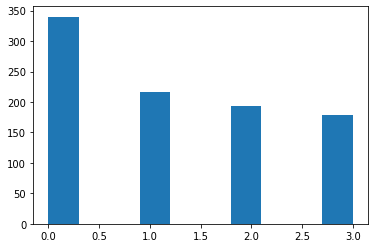

In [402]:
plt.hist(a1_talk[:][scores1[:] == 3])

(array([1881.,    0.,    0., 1042.,    0.,    0., 1049.,    0.,    0.,
        1028.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

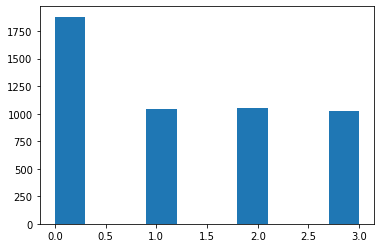

In [403]:
plt.hist(a1_talk)

No option of not to talk

In [384]:
#agent1 gets inputs from bimodal distribution + punishment increase
class One_Talking_No_Time_Best_World():

    # Enumeration of possible actions
    class Actions():
        #silence = 0
        a = 0
        b = 1
        c = 2
        nothing = 3
        choose_1 = 4
        choose_2 = 5
        choose_3 = 6 #etc
        # choose entity - entity number (the range(num of entities))

    def __init__(
        self, num_ent, winning_reward, talking_reward = 0): 

        # Action enumeration for this environment
        d = {1:"a",2:"b",3:"c"}
        for i in range(num_ent):
            d[i+4] = str(i+1)
        self.actions = d
        self.num_ent = num_ent
        self.winning_reward = winning_reward
        self.talking_reward = talking_reward
        self.beta_punishment = 1
        self.punishment = 0.5 #-1
        self.talking_decay = 0.995
                
    def step(self, ag1_action, ag2_action, ag3_action, choose, reward1 = 0, reward2 = 0, reward3 = 0):
        ag3_input = np.array([random.random()]) # adversarial agent does not know anything
        ag1_input = np.array([np.random.normal(0,1), np.random.normal(3,1), np.random.normal(5,1)]) #uniform
        ag2_input = np.random.normal(0,0.1,(4,)) #talking binary (3) + noise
                
        if choose: # step of choice
            if ag2_action == ag1_action: 
                self.punishment = self.beta_punishment * self.punishment # punishment change
                if ag3_action == ag2_action: #caught in place
                    reward3 = 1
                    reward1 = self.punishment
                    reward2 = self.punishment
                else:
                    reward3 = -1
                    reward1 = self.winning_reward
                    reward2 = self.winning_reward
            else:
                reward1 = self.punishment
                reward2 = self.punishment
                if ag1_action == ag3_action or ag2_action == ag3_action:
                    reward3 = 1
                else:
                    reward3 = -1
                    
        else: # agent 1 talking 
            ag1_action += 1
            if ag1_action == 1:
                ag2_input[0] += 1
                reward1 = self.talking_reward # * 0.995
            elif ag1_action == 2:
                ag2_input[1] += 1
                reward1 = self.talking_reward # * 0.995
            elif ag1_action == 3:
                ag2_input[2] += 1
                reward1 = self.talking_reward # * 0.995
        
        return(ag1_input, ag2_input, ag3_input, reward1, reward2, reward3)

In [385]:
env = One_Talking_No_Time_Best_World(3, 3, 0)

In [386]:
# Deep Q-learning Agent
class DQNAgent_2_optim_memory:
    def __init__(self, state_size, talking_action_size, choices):
        self.state_size = state_size
        self.opt_memory = collections.deque(maxlen=100)
        self.memory = collections.deque(maxlen=100)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.1
        self.epsilon_decay = 0.9999
        self.learning_rate_bad = 0.001
        self.learning_rate_good = 0.01

        self.talking_action_size = talking_action_size
        self.choices = choices
        self.model = self._build_model()

    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        #t = 0
        model = Sequential()
        model.add(Dense(6, input_dim=self.state_size, activation='tanh'))
        #model.add(Dense(6, activation='relu'))
        #if self.talking_action_size > 0:
        #    t = 1 # nothing for talking
        model.add(Dense(self.talking_action_size + self.choices + 1, activation='linear'))
        model.compile(loss='mse',
                      optimizer=Adam(lr=self.learning_rate_bad))
        return model
    
    def remember(self, state, action, reward, next_state):
        if reward > 2:
            self.opt_memory.append((state, action, reward, next_state))
        else:
            self.memory.append((state, action, reward, next_state))
                           
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            if self.talking_action_size == 0:
                return random.randrange(self.choices+1)
            else:
                return [random.randrange(self.talking_action_size), random.randrange(self.choices+1)]
        state = np.expand_dims(state, axis=0)
        act_values = self.model.predict(state, batch_size=1)
        if self.talking_action_size == 0:
            return np.argmax(act_values[0])  # returns choice from 0 to n-1
        else:
            talk = np.argmax(act_values[0][:self.talking_action_size])
            choice = np.argmax(act_values[0][self.talking_action_size:]) # returns choice from 0 to n-1
            return [talk, choice]
                           
    def replay(self, batch_size, memory_type):
        if memory_type == "normal":
            minibatch = random.sample(self.memory, batch_size)
        elif memory_type == "optimistic":
            minibatch = random.sample(self.opt_memory, batch_size)
        for state, action, reward, next_state in minibatch:
            next_state = np.expand_dims(next_state, axis=0)
            state = np.expand_dims(state, axis=0)
            target = reward
            if target>2: # won the game
                K.set_value(self.model.optimizer.lr, self.learning_rate_good) 
            else:
                K.set_value(self.model.optimizer.lr, self.learning_rate_bad)
            if self.talking_action_size == 0:
            #if not done:
            #    target = reward + self.gamma * np.amax(self.model.predict(next_state, batch_size=1)[0])
                target_f = self.model.predict(state, batch_size=1)
                target_f[0][action] = target
                self.model.fit(state, target_f, batch_size=1, epochs=1, verbose=0)
            else:
                target_f = self.model.predict(state, batch_size=1)
                target_f[0][action[0]] = target # talk
                target_f[0][action[1]+self.talking_action_size] = target # choose
                self.model.fit(state, target_f, batch_size=1, epochs=1, verbose=0)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [387]:
agent1 = DQNAgent_2_optim_memory(3, 3, 3) # can talk
agent2 = DQNAgent_2_optim_memory(4, 0, 3) # receive talkings
agent3 = DQNAgent_2_optim_memory(1, 0, 3)

In [395]:
# Iterate the game
episodes = 3000
a1_talk = []
a1_act = []
a2 = []
a3 = []
scores1 = []
scores2 = []
scores3 = []
states2 = []

for e in range(episodes):
    i = 1
    score1 = 0
    score2 = 0
    score3 = 0
    
    state1, _, _, _, _, _ = env.step(0, 0, 1, 0) # 4 - doing nothing 
    
    # agent 1 talks
    action1 = agent1.act(state1)
    
    state1, state2, state3, reward1, reward2, reward3 = env.step(action1[0], 4, 1, 0)     
    score1 += reward1
    
    action2 = agent2.act(state2)
    action3 = agent3.act(state3)
    
    # everyone chooses
    next_state1, next_state2, next_state3, reward1, reward2, reward3 = env.step(action1[1], action2, action3, 1)     
        
    score1 += reward1
    score2 += reward2
    score3 += reward3
        
    # remembering weighted by the reward
    #if random.random() < (score1 + 2.2):
    #if len(agent1.opt_memory) < 6:
    agent2.remember(state2, action2, reward2, next_state2)
    agent1.remember(state1, action1, reward1, next_state1)
    
    agent3.remember(state3, action3, reward3, next_state3)


    print("episode: {}/{}, score1: {}, score2: {}, score3:{}"
                  .format(e, episodes, score1, score2, score3))
    if e%100 ==0:
        if len(agent1.opt_memory) > 50 and len(agent2.opt_memory) > 50: 
            agent1.replay(50, "optimistic")
            agent2.replay(50, "optimistic")
    
            agent3.replay(1, "normal")
        #if e%i == 0:
        #if len(agent1.memory) > 1:
            agent2.replay(10, "normal")
            agent1.replay(10, "normal")
        #    i += 1
    
    states2.append(state2)
    a1_talk.append(action1[0])
    a1_act.append(action1[1])
    a2.append(action2)
    a3.append(action3)
    scores1.append(score1)
    scores2.append(score2)
    scores3.append(score3)

episode: 0/3000, score1: 0.5, score2: 0.5, score3:-1
episode: 1/3000, score1: 0.5, score2: 0.5, score3:1
episode: 2/3000, score1: 0.5, score2: 0.5, score3:1
episode: 3/3000, score1: 0.5, score2: 0.5, score3:-1
episode: 4/3000, score1: 0.5, score2: 0.5, score3:-1
episode: 5/3000, score1: 0.5, score2: 0.5, score3:-1
episode: 6/3000, score1: 0.5, score2: 0.5, score3:1
episode: 7/3000, score1: 0.5, score2: 0.5, score3:-1
episode: 8/3000, score1: 0.5, score2: 0.5, score3:-1
episode: 9/3000, score1: 0.5, score2: 0.5, score3:1
episode: 10/3000, score1: 3, score2: 3, score3:-1
episode: 11/3000, score1: 0.5, score2: 0.5, score3:-1
episode: 12/3000, score1: 0.5, score2: 0.5, score3:1
episode: 13/3000, score1: 0.5, score2: 0.5, score3:1
episode: 14/3000, score1: 3, score2: 3, score3:-1
episode: 15/3000, score1: 0.5, score2: 0.5, score3:1
episode: 16/3000, score1: 0.5, score2: 0.5, score3:1
episode: 17/3000, score1: 3, score2: 3, score3:-1
episode: 18/3000, score1: 0.5, score2: 0.5, score3:1
episo

In [389]:
scores1 = np.array(scores1)
a1_talk = np.array(a1_talk)
a1_act = np.array(a1_act)
a2 = np.array(a2)

In [390]:
a1_talk[:][scores1[:] == 3]

array([2, 2, 1, 0, 2, 2, 0, 0, 0, 2, 1, 2, 2, 1, 1, 1, 2, 1, 2, 0, 1, 2,
       2, 2, 2, 0, 2, 2, 0, 0, 2, 2, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 2, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 2, 1, 1, 2, 1, 1, 0,
       2, 0, 2, 0, 2, 2, 0, 2, 2, 2, 1, 0, 0, 0, 0, 0, 2, 1, 1, 1, 1, 0,
       1, 0, 0, 1, 0, 1, 2, 1, 0, 2, 2, 2, 0, 1, 2, 2, 0, 0, 2, 1, 1, 0,
       0, 1, 0, 2, 0, 1, 2, 0, 1, 2, 1, 1, 2, 1, 0, 0, 0, 2, 1, 1, 1, 0,
       0, 2, 2, 1, 1, 0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 0, 2, 0, 0, 2, 0,
       1, 0, 1, 2, 1, 0, 0, 1, 1, 1, 0, 2, 1, 0, 0, 1, 2, 0, 1, 2, 1, 2,
       0, 2, 0, 0, 1, 0, 2, 1, 0, 1, 2, 1, 0, 1, 0, 1, 2, 2, 0, 2, 1, 2,
       1, 0, 0, 2, 1, 1, 1, 0, 1, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 0, 2,
       0, 0, 1, 0, 0, 2, 2, 0, 1, 1, 2, 2, 0, 0, 0, 0, 1, 1, 1, 2, 0, 0,
       2, 1, 0, 0, 0, 0, 1, 0, 1, 2, 0, 0, 0, 0, 0, 1, 2, 1, 1, 0, 1, 1,
       1, 2, 1, 0, 0, 0, 0, 1, 2, 0, 0, 1, 2, 2, 0, 2, 2, 0, 1, 1, 1, 0,
       1, 1, 2, 0, 1, 0, 1, 0, 2, 1, 0, 1, 1, 2, 1,

(array([211.,   0.,   0.,   0.,   0., 193.,   0.,   0.,   0., 166.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

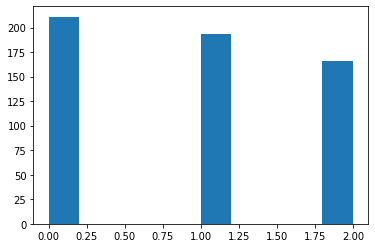

In [391]:
plt.hist(a1_talk[:][scores1[:] == 3])

(array([1006.,    0.,    0.,    0.,    0., 1011.,    0.,    0.,    0.,
         983.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

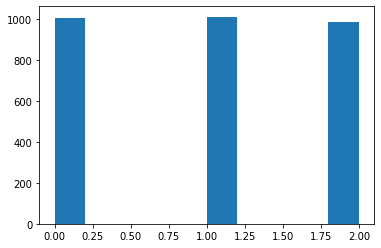

In [392]:
plt.hist(a1_talk)

(array([243.,   0.,   0., 271.,   0.,   0., 278.,   0.,   0., 214.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

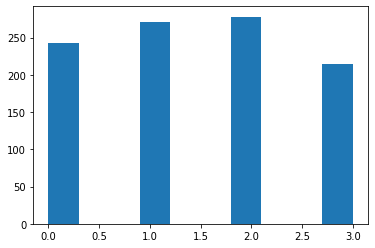

In [393]:
plt.hist(a1_act[:][a1_talk[:] == 0])

(array([283.,   0.,   0., 233.,   0.,   0., 226.,   0.,   0., 264.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

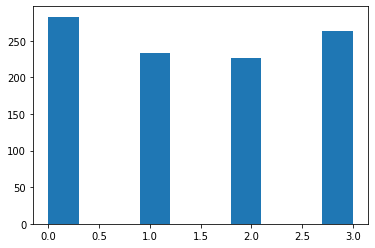

In [394]:
plt.hist(a2[:][a1_talk[:] == 0])

In [36]:
a1_talk[:5]

array([0, 2, 2, 2, 1])

(array([  3.,  13.,  46.,  78., 116., 120.,  66.,  36.,  18.,   4.]),
 array([-4.28117067, -3.41704368, -2.55291669, -1.6887897 , -0.82466272,
         0.03946427,  0.90359126,  1.76771825,  2.63184524,  3.49597223,
         4.36009922]),
 <a list of 10 Patch objects>)

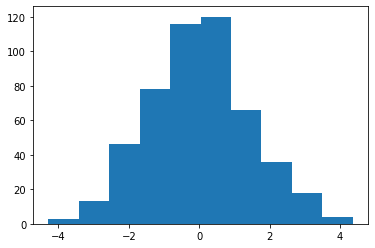

In [261]:
plt.hist(np.random.normal(0,1,500) + np.random.normal(0,1,500))

### Cultural transmission

In [480]:
class One_Talking_No_Time_Best_World():

    # Enumeration of possible actions
    class Actions():
        silence = 0
        a = 1
        b = 2
        c = 3
        nothing = 4
        choose_1 = 5
        choose_2 = 6
        choose_3 = 7 #etc
        # choose entity - entity number (the range(num of entities))

    def __init__(
        self, num_ent, winning_reward, talking_reward = 0): #choose true or false

        # Action enumeration for this environment
        d = {1:"a",2:"b",3:"c"}
        for i in range(num_ent):
            d[i+4] = str(i+1)
        self.actions = d
        self.num_ent = num_ent
        self.winning_reward = winning_reward
        self.talking_reward = talking_reward
        self.talking_decay = 0.995
                
    def step(self, ag1_action, ag2_action, ag3_action, choose, reward1 = 0, reward2 = 0, reward3 = 0):
        ag3_input = np.array([random.random()]) # adversarial agent does not know anything
        ag1_input = np.array([np.random.beta(0.5,0.5)]) #UNIFORM/bimodal NOISE
        ag2_input = np.random.normal(0,0.1,(4,)) #talking binary (3) + noise
                
        if choose: # step of choice
            if ag2_action == ag1_action: 
                if ag3_action == ag2_action: #caught in place
                    reward3 = 1
                    reward1 = -1
                    reward2 = -1
                else:
                    reward3 = -1
                    reward1 = self.winning_reward
                    reward2 = self.winning_reward
            else:
                reward1 = -1
                reward2 = -1
                if ag1_action == ag3_action or ag2_action == ag3_action:
                    reward3 = 1
                else:
                    reward3 = -1
                    
        else: # agent 1 talking 
            if ag1_action == 1:
                ag2_input[0] += 1
                reward1 = self.talking_reward # * 0.995
            elif ag1_action == 2:
                ag2_input[1] += 1
                reward1 = self.talking_reward # * 0.995
            elif ag1_action == 3:
                ag2_input[2] += 1
                reward1 = self.talking_reward # * 0.995
        
        return(ag1_input, ag2_input, ag3_input, reward1, reward2, reward3)

In [481]:
# Deep Q-learning Agent
class DQNAgent_2:
    def __init__(self, state_size, talking_action_size, choices):
        self.state_size = state_size
        self.memory = collections.deque(maxlen=100)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.3
        self.epsilon_decay = 0.999
        self.learning_rate_bad = 0.0001
        self.learning_rate_good = 0.01

        self.talking_action_size = talking_action_size
        self.choices = choices
        self.model = self._build_model()

    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        t = 0
        model = Sequential()
        model.add(Dense(3, input_dim=self.state_size, activation='relu'))
        model.add(Dense(3, activation='relu'))
        if self.talking_action_size > 0:
            t = 1 # nothing for talking
        model.add(Dense(self.talking_action_size + t + self.choices + 1, activation='linear'))
        model.compile(loss='mse',
                      optimizer=Adam(lr=self.learning_rate_bad))
        return model
    
    def remember(self, state, action, reward, next_state):
        self.memory.append((state, action, reward, next_state))
                           
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            if self.talking_action_size == 0:
                return random.randrange(self.choices+1)
            else:
                return [random.randrange(self.talking_action_size+1), random.randrange(self.choices+1)]
        state = np.expand_dims(state, axis=0)
        act_values = self.model.predict(state, batch_size=1)
        if self.talking_action_size == 0:
            return np.argmax(act_values[0])  # returns choice from 0 to n-1
        else:
            talk = np.argmax(act_values[0][:self.talking_action_size+1])
            choice = np.argmax(act_values[0][self.talking_action_size+1:]) # returns choice from 0 to n-1
            return [talk, choice]
                           
    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state in minibatch:
            next_state = np.expand_dims(next_state, axis=0)
            state = np.expand_dims(state, axis=0)
            target = reward
            if target>2: # won the game
                K.set_value(self.model.optimizer.lr, self.learning_rate_good) 
            else:
                K.set_value(self.model.optimizer.lr, self.learning_rate_bad)
            if self.talking_action_size == 0:
            #if not done:
            #    target = reward + self.gamma * np.amax(self.model.predict(next_state, batch_size=1)[0])
                target_f = self.model.predict(state, batch_size=1)
                target_f[0][action] = target
                self.model.fit(state, target_f, batch_size=1, epochs=1, verbose=0)
            else:
                target_f = self.model.predict(state, batch_size=1)
                target_f[0][action[0]] = target # talk
                target_f[0][action[1]+self.talking_action_size+1] = target # choose
                self.model.fit(state, target_f, batch_size=1, epochs=1, verbose=0)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [482]:
agent1 = DQNAgent_2(1, 3, 3) # can talk
agent2 = DQNAgent_2(4, 0, 3) # receive talkings
agent3 = DQNAgent_2(1, 0, 3)

In [483]:
env = One_Talking_No_Time_Best_World(3, 3, 0)

In [484]:
# Iterate the game
episodes = 1500
a1_talk = []
a1_act = []
a2 = []
a3 = []
scores1 = []
scores2 = []
scores3 = []

wins = 1
loses = 1

for e in range(episodes):
    score1 = 0
    score2 = 0
    score3 = 0
    
    state1, state2, state3, _, _, _ = env.step(0, 0, 1, 0) # 4 - doing nothing 
    
    # agent 1 talks
    action1 = agent1.act(state1)
    
    state1, state2, state3, reward1, reward2, reward3 = env.step(action1[0], 4, 1, 0)     
    score1 += reward1
    
    action2 = agent2.act(state2)
    action3 = agent3.act(state3)
    
    # everyone chooses
    next_state1, next_state2, next_state3, reward1, reward2, reward3 = env.step(action1[1], action2, action3, 1)     
        
    score1 += reward1
    score2 += reward2
    score3 += reward3
    if reward1 > 2: #won the game
        wins += 1
    else:
        loses += 1
        
    # remembering weighted by the reward
    #if random.random() < (score1 + 2.2):
    agent2.remember(state2, action2, reward2, next_state2)
    agent1.remember(state1, action1, reward1, next_state1)
    agent3.remember(state3, action3, reward3, next_state3)


    print("episode: {}/{}, score1: {}, score2: {}, score3:{}"
                  .format(e, episodes, score1, score2, score3))
    if len(agent1.memory) > 10 and len(agent2.memory) > 10: 
        if wins/loses < np.random.uniform(0,2):   
            agent1.replay(10)
            agent2.replay(10)
    
    if len(agent3.memory) > 10:
        agent3.replay(10)
    
    a1_talk.append(action1[0])
    a1_act.append(action1[1])
    a2.append(action2)
    a3.append(action3)
    scores1.append(score1)
    scores2.append(score2)
    scores3.append(score3)

episode: 0/1500, score1: -1, score2: -1, score3:1
episode: 1/1500, score1: 3, score2: 3, score3:-1
episode: 2/1500, score1: -1, score2: -1, score3:-1
episode: 3/1500, score1: -1, score2: -1, score3:-1
episode: 4/1500, score1: 3, score2: 3, score3:-1
episode: 5/1500, score1: 3, score2: 3, score3:-1
episode: 6/1500, score1: 3, score2: 3, score3:-1
episode: 7/1500, score1: -1, score2: -1, score3:1
episode: 8/1500, score1: 3, score2: 3, score3:-1
episode: 9/1500, score1: -1, score2: -1, score3:1
episode: 10/1500, score1: 3, score2: 3, score3:-1
episode: 11/1500, score1: -1, score2: -1, score3:-1
episode: 12/1500, score1: -1, score2: -1, score3:1
episode: 13/1500, score1: -1, score2: -1, score3:-1
episode: 14/1500, score1: -1, score2: -1, score3:1
episode: 15/1500, score1: -1, score2: -1, score3:-1
episode: 16/1500, score1: 3, score2: 3, score3:-1
episode: 17/1500, score1: -1, score2: -1, score3:-1
episode: 18/1500, score1: 3, score2: 3, score3:-1
episode: 19/1500, score1: -1, score2: -1, s

KeyboardInterrupt: 

In [485]:
scores1 = np.array(scores1)
a1_talk = np.array(a1_talk)
a1_act = np.array(a1_act)
a2 = np.array(a2)